In [2]:
import os
import librosa
import numpy as np
import IPython.display as ipd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
import io
import time
import seaborn as sns
import pandas as pd


In [3]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from IPython.display import Audio
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import VectorAssembler



# Exploratory Data Analysis
### The purpose is to discover patterns, anomalies, relationships, and trends in the dataset by using statistical graphics, data summaries, and other methods, rather than setting hypotheses from the beginning.
## 1 Exploring the Audio Data

In [5]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("AudioFilesProcessing") \
    .config("spark.master", "local[8]") \
    .getOrCreate()

# Set the directory for audio files
data = "/user1/audio"

# Read audio files using binaryFiles
files_rdd = spark.sparkContext.binaryFiles(data)

# Collect all file paths
all_files = files_rdd.keys().collect()

# Print the first few file paths
for file_path in all_files[:10]:
    print(file_path)


24/04/06 19:34:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


hdfs://localhost:9000/user1/audio/1-100032-A-0.wav
hdfs://localhost:9000/user1/audio/1-100038-A-14.wav
hdfs://localhost:9000/user1/audio/1-100210-A-36.wav
hdfs://localhost:9000/user1/audio/1-100210-B-36.wav
hdfs://localhost:9000/user1/audio/1-101296-A-19.wav
hdfs://localhost:9000/user1/audio/1-101296-B-19.wav
hdfs://localhost:9000/user1/audio/1-101336-A-30.wav
hdfs://localhost:9000/user1/audio/1-101404-A-34.wav
hdfs://localhost:9000/user1/audio/1-103298-A-9.wav
hdfs://localhost:9000/user1/audio/1-103995-A-30.wav


In [6]:
# Calculate the number of files
num_files = files_rdd.count()
print(f"Total number of files: {num_files}")


Total number of files: 2000


In [7]:
# Check for files with no content
empty_files = files_rdd.filter(lambda file: len(file[1]) == 0).keys().collect()
print(f"Number of empty files: {len(empty_files)}")
if len(empty_files) > 0:
    print("Empty files:", empty_files)

# Check audio length and get the first audio information
first_audio_file = files_rdd.first()
first_audio_path, first_audio_content = first_audio_file
y, sr = librosa.load(io.BytesIO(first_audio_content), sr=None)
duration = librosa.get_duration(y=y, sr=sr)

# Display the first audio
audio = Audio(data=first_audio_content)
display(audio)

# Print audio information
print(f"y shape: {y.shape}")
print(f"Sample Rate (KHz): {sr/1000}")
print(f"Duration of the audio file: {duration} seconds")


Number of empty files: 0


y shape: (220500,)
Sample Rate (KHz): 44.1
Duration of the audio file: 5.0 seconds


In [8]:
# Define a function to check audio length
def check_audio_length(file):
    _, content = file
    try:
        audio, sample_rate = librosa.load(io.BytesIO(content), sr=None)
        duration = librosa.get_duration(y=audio, sr=sample_rate)
        return abs(duration - 5.0) < 0.05  # Allow some margin for error
    except Exception as e:
        return False

# Filter out audio files that are not 5 seconds long
not_five_seconds_files = files_rdd.filter(lambda file: not check_audio_length(file)).keys().collect()

# Print information based on the filter result
if not_five_seconds_files:
    print("Files not 5 seconds long:")
    for file_path in not_five_seconds_files:
        print(file_path)
else:
    print("All files are 5 seconds long.")


All files are 5 seconds long.


In [9]:
# Set the path for the CSV file containing metadata
csv_path = "/user1/esc50.csv"

# Read the CSV file and create a DataFrame
dataset = spark.read.csv(csv_path, header=True, inferSchema=True)

# Print the schema of the DataFrame
dataset.printSchema()


root
 |-- filename: string (nullable = true)
 |-- fold: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- esc10: boolean (nullable = true)
 |-- src_file: integer (nullable = true)
 |-- take: string (nullable = true)



In [10]:
dataset.show(10,truncate = False)

+-----------------+----+------+---------------+-----+--------+----+
|filename         |fold|target|category       |esc10|src_file|take|
+-----------------+----+------+---------------+-----+--------+----+
|1-100032-A-0.wav |1   |0     |dog            |true |100032  |A   |
|1-100038-A-14.wav|1   |14    |chirping_birds |false|100038  |A   |
|1-100210-A-36.wav|1   |36    |vacuum_cleaner |false|100210  |A   |
|1-100210-B-36.wav|1   |36    |vacuum_cleaner |false|100210  |B   |
|1-101296-A-19.wav|1   |19    |thunderstorm   |false|101296  |A   |
|1-101296-B-19.wav|1   |19    |thunderstorm   |false|101296  |B   |
|1-101336-A-30.wav|1   |30    |door_wood_knock|false|101336  |A   |
|1-101404-A-34.wav|1   |34    |can_opening    |false|101404  |A   |
|1-103298-A-9.wav |1   |9     |crow           |false|103298  |A   |
|1-103995-A-30.wav|1   |30    |door_wood_knock|false|103995  |A   |
+-----------------+----+------+---------------+-----+--------+----+
only showing top 10 rows



## 2 Distribution of Categories

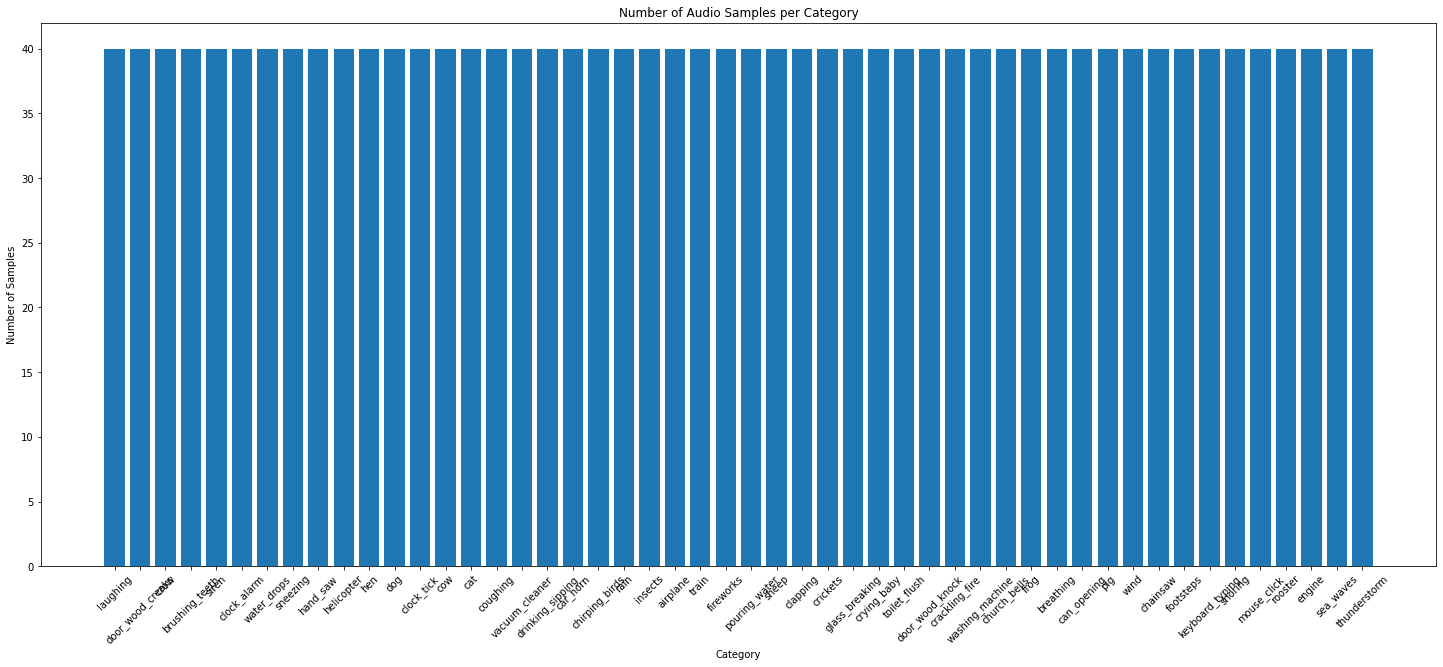

In [11]:
category_counts = dataset.groupBy("category").count()

category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(25, 10))

plt.bar(category_counts_pd['category'], category_counts_pd['count'])

plt.title('Number of Audio Samples per Category')
plt.xlabel('Category')
plt.ylabel('Number of Samples')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


## 3 Visualizetion : Sound Waves

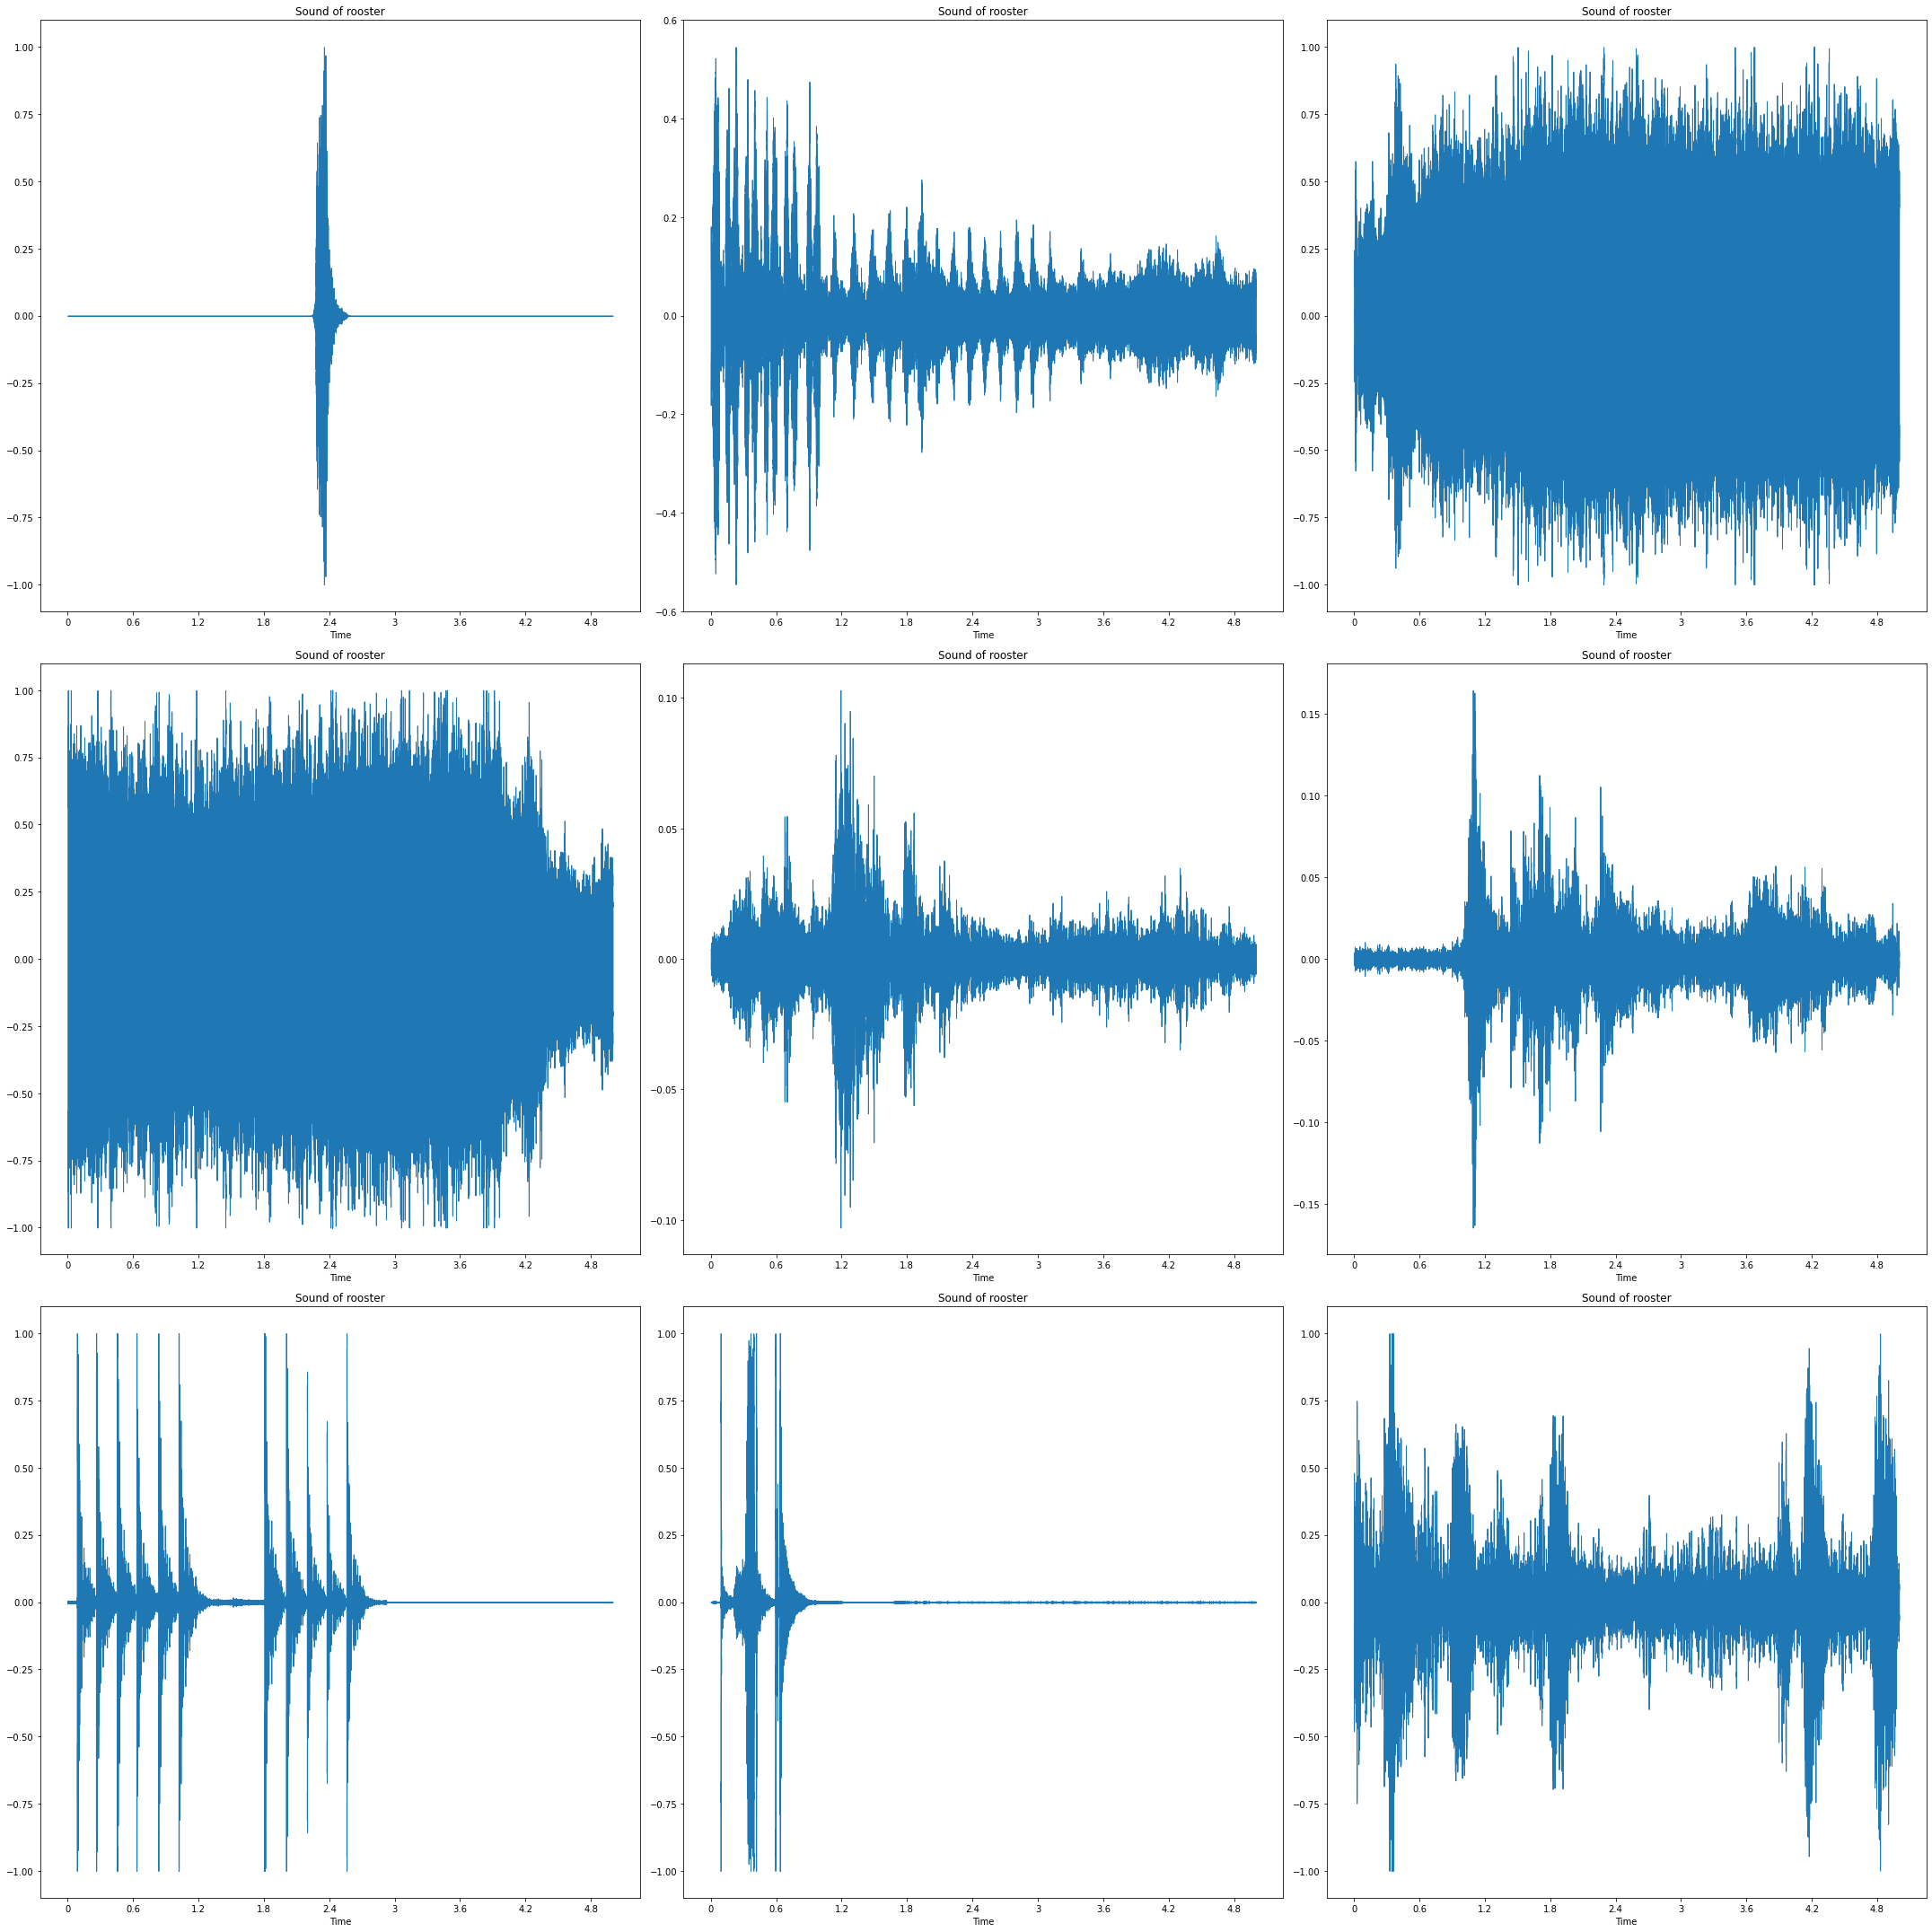

In [12]:
limited_files_rdd = files_rdd.zipWithIndex().filter(lambda x: x[1] < 9).map(lambda x: x[0])

decoder = {0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock',
           34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 
           31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 
           46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 
           4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 
           40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 
           6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 
           39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 
           38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 
           33: 'door_wood_creaks', 13: 'crickets'}

# Define a function to load audio and extract necessary information
def extract_audio_info(file):
    file_path, content = file
    y, sr = librosa.load(io.BytesIO(content), sr=None)
    file_id = int(os.path.basename(file_path).split('-')[0])
    return (file_id, y, sr)

# Apply the function and collect data
audio_info = limited_files_rdd.map(extract_audio_info).collect()

plt.figure(figsize=(30, 30))

# For each collected audio information, plot the waveform
for i, (file_id, y, sr) in enumerate(audio_info, start=1):
    plt.subplot(3, 3, i)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Sound of " + decoder.get(file_id, "Unknown"))

plt.tight_layout()  # Adjust subplot spacing
plt.show()


## 4 The Mel Spectrogram
### A mel spectrogram converts frequencies to the mel scale, which approximates human hearing by rendering frequencies logarithmically above a certain threshold. It ensures the spacing between frequency ranges is perceived more uniformly, making it easier to distinguish between low-frequency sounds compared to high-frequency sounds. It calculates its output by applying a filter bank to frequency-domain values.

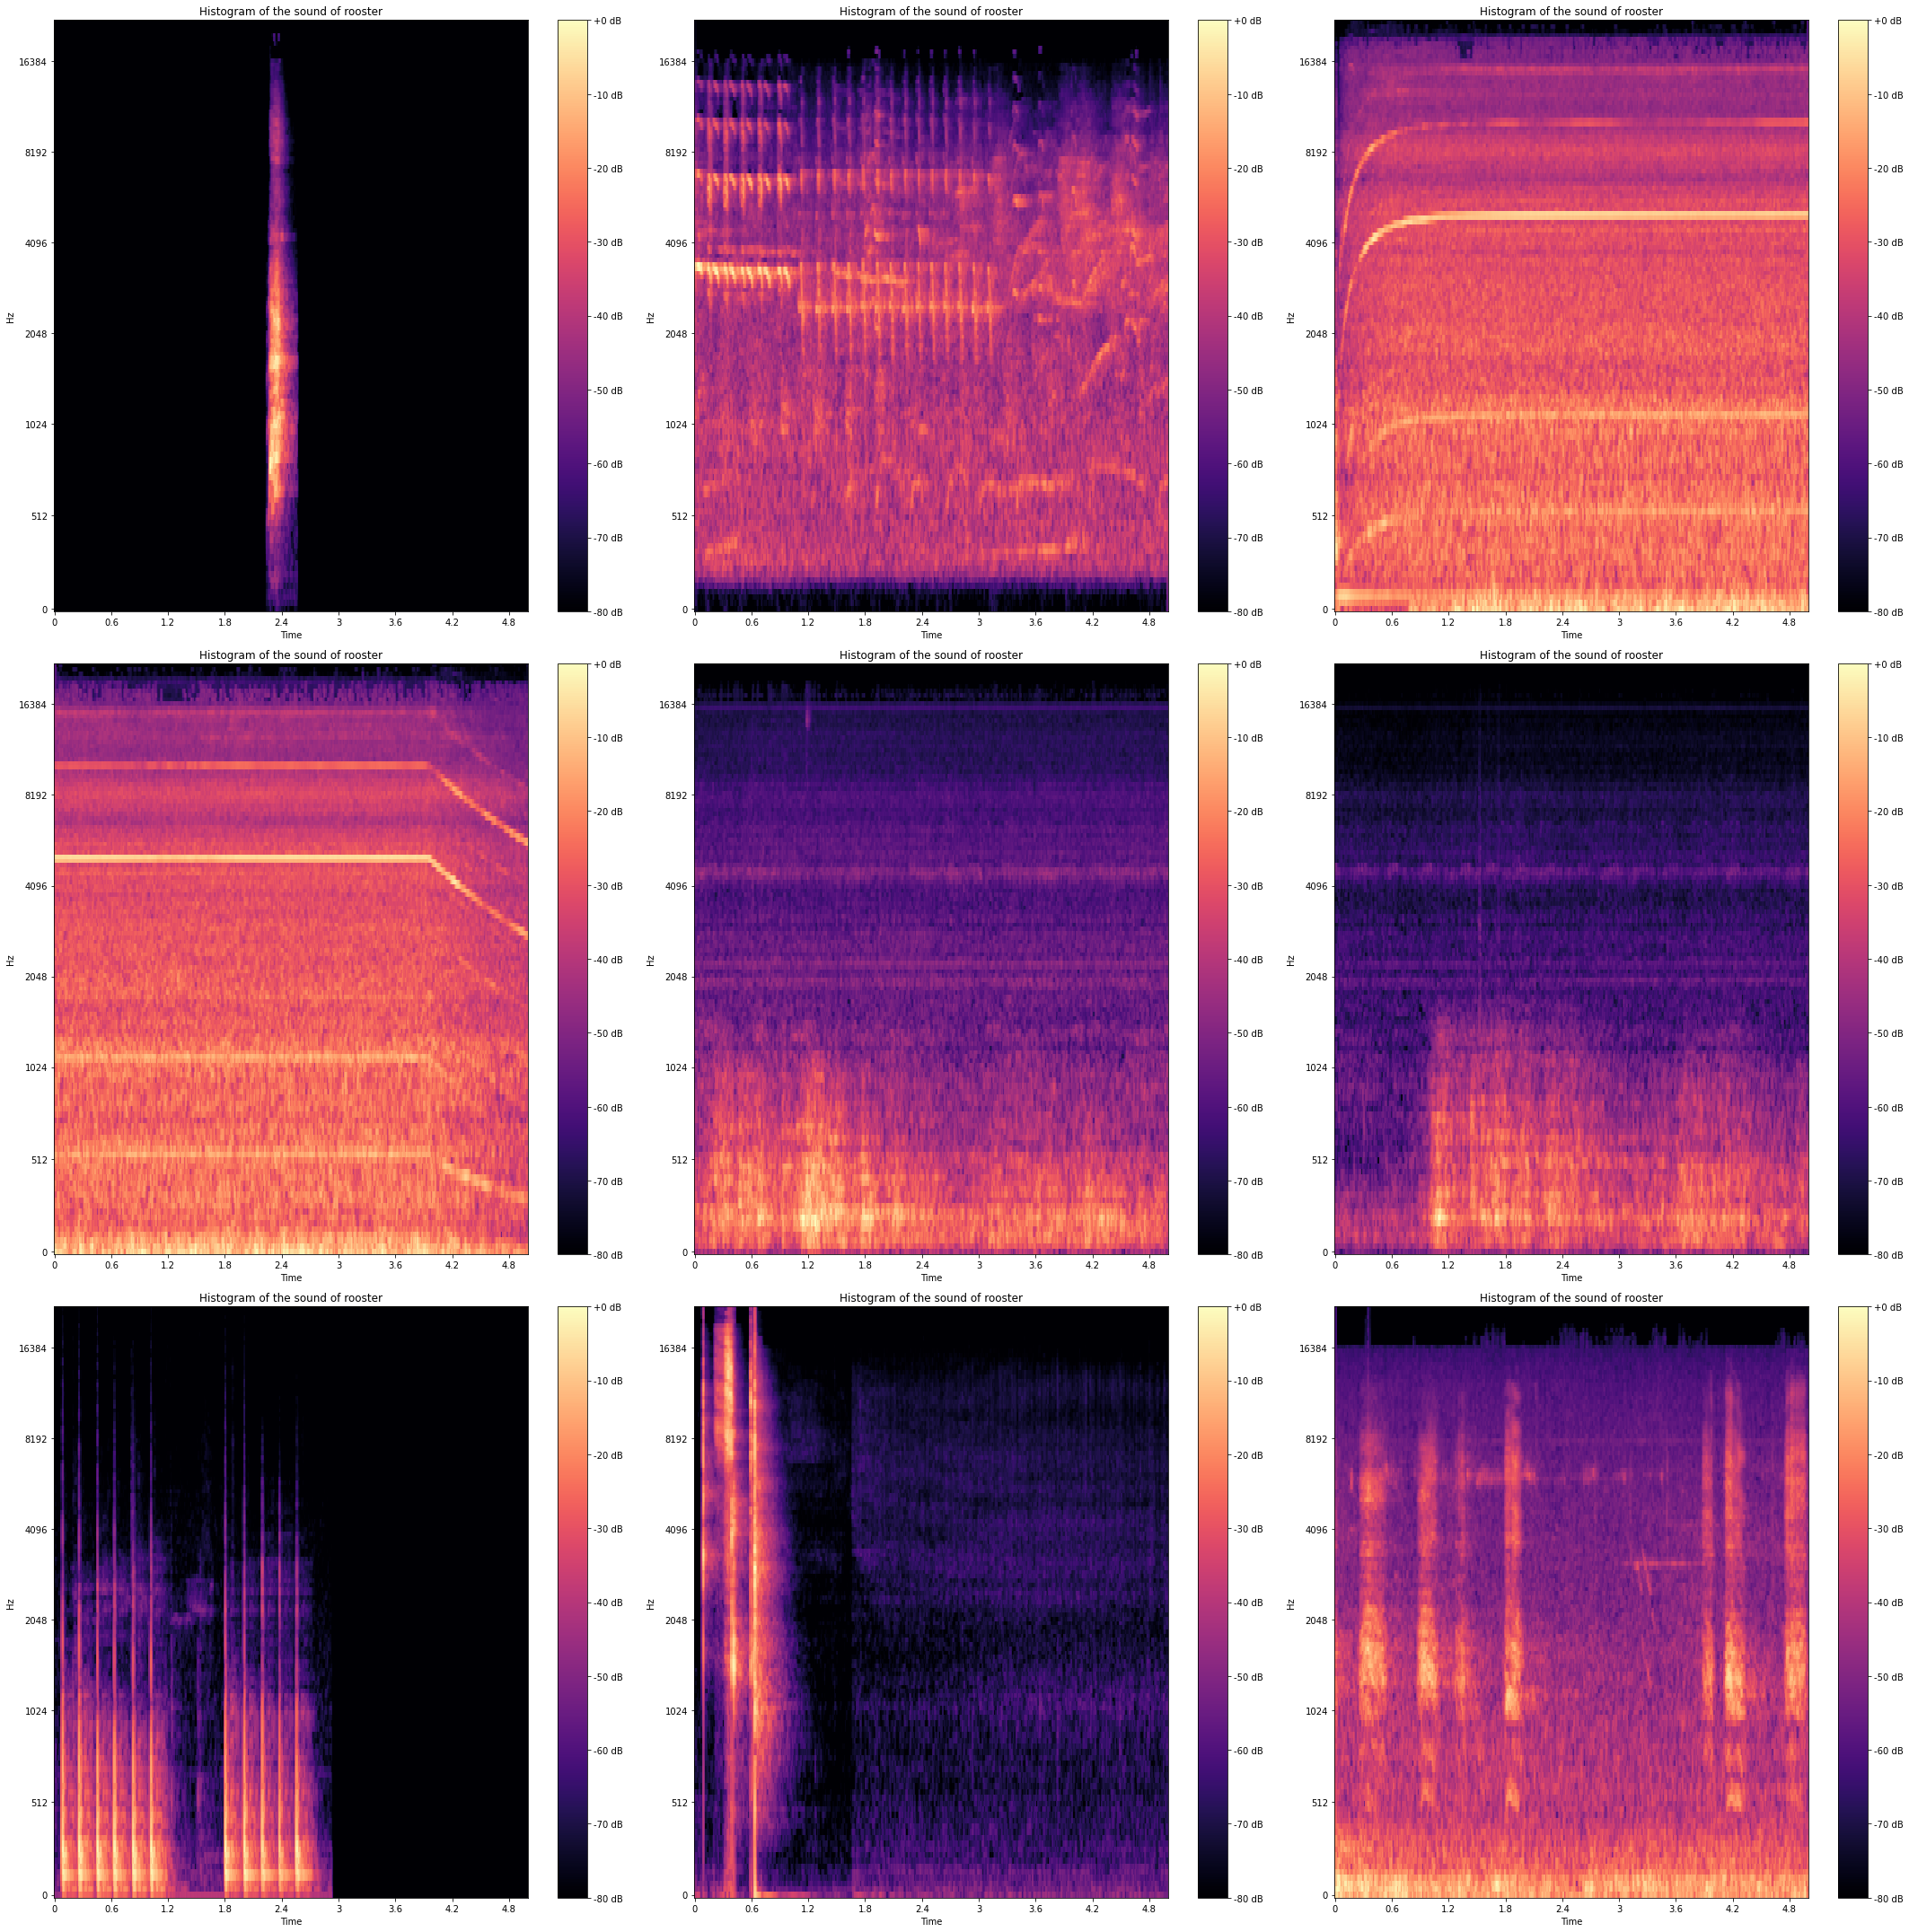

In [13]:
def extract_melspectrogram(file):
    file_path, content = file
    try:
        # Load the audio file from binary content
        y, sr = librosa.load(io.BytesIO(content), sr=None)
        # Compute the Mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        # Convert to decibel scale
        S_dB = librosa.power_to_db(S, ref=np.max)
        # Extract the file ID from the filename
        file_id = int(os.path.basename(file_path).split('-')[0])
        return (file_id, S_dB, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return (file_path, None, None)

# Apply the function and collect data
melspectrogram_info = limited_files_rdd.map(extract_melspectrogram).collect()

plt.figure(figsize=(30, 30))

for i, (file_id, S_dB, sr) in enumerate(melspectrogram_info, start=1):
    if S_dB is not None:
        plt.subplot(3, 3, i)
        # Plot the Mel spectrogram
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Histogram of the sound of " + decoder.get(file_id, "Unknown"))

plt.tight_layout()  # Adjust subplot spacing
plt.show()


## 5 Mel-Frequency Cepstral Coefficients(MFCCs)
### Mel-Frequency Cepstral Coefficients (MFCCs) are features representing an audio signal's spectral characteristics, designed based on human sound perception. To calculate MFCCs, the audio is first converted to the frequency domain, then scaled to the Mel scale to mimic the human ear's response. After taking the logarithm of Mel-frequency energies and applying a Discrete Cosine Transform (DCT), a set of coefficients capturing the spectral envelope is produced. Typically using 12 to 40 coefficients, MFCCs are effective for speech and music processing tasks, including recognition and classification, due to their robustness to audio variations. They can be combined with other features for enhanced audio analysis.

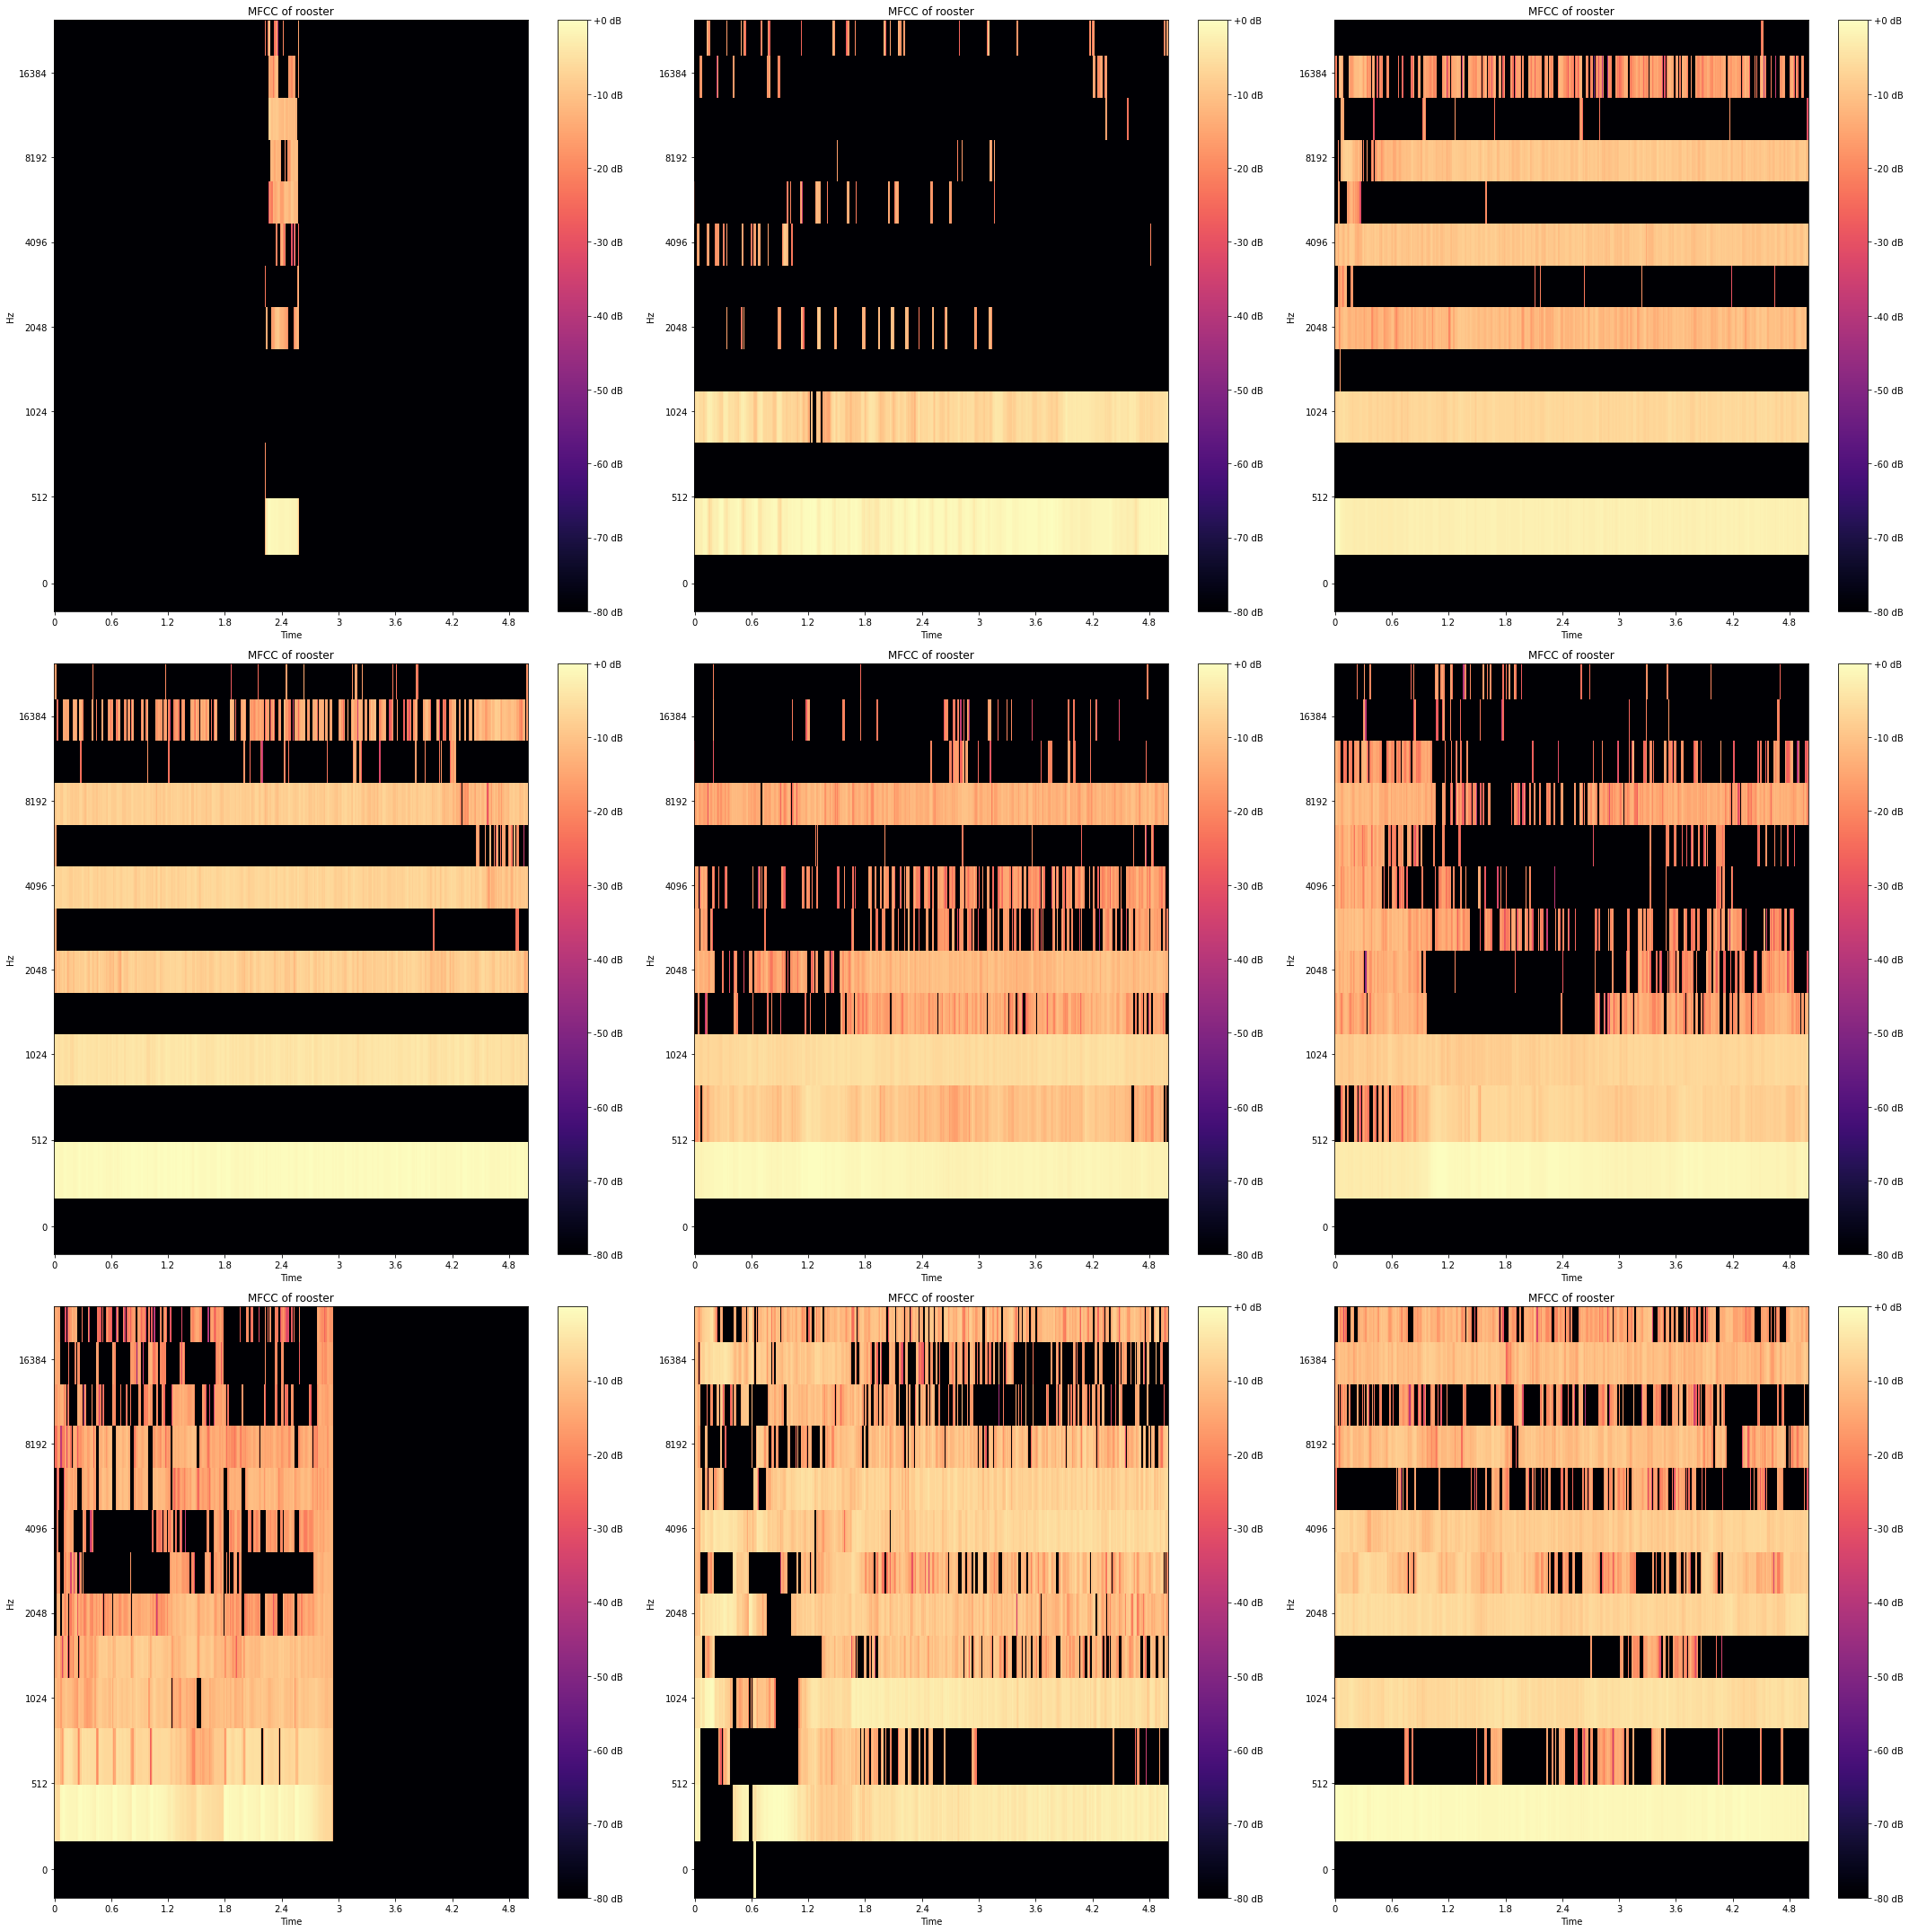

In [14]:
# Define a function to extract MFCC
def extract_mfcc(file):
    file_path, content = file
    try:
        # Load the audio file from binary content
        y, sr = librosa.load(io.BytesIO(content), sr=None)
        # Compute MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        # Convert MFCCs to decibel scale
        mfcc_dB = librosa.power_to_db(mfcc, ref=np.max)
        # Extract the file ID from the filename
        file_id = int(os.path.basename(file_path).split('-')[0])
        return (file_id, mfcc_dB, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return (file_path, None, None)


mfcc_info = limited_files_rdd.map(extract_mfcc).collect()


plt.figure(figsize=(30, 30))

# Plot MFCCs for each audio file
for i, (file_id, mfcc_dB, sr) in enumerate(mfcc_info[:9], start=1):
    if mfcc_dB is not None:
        plt.subplot(3, 3, i)
        librosa.display.specshow(mfcc_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title("MFCC of " + decoder.get(file_id, "Unknown"))

plt.tight_layout()  # Adjust subplot spacing
plt.show()


## 6 Data Augmentation
### Data augmentation artificially expands a dataset by transforming existing data, enhancing machine learning model robustness by introducing variability. For the ESC-50 dataset, techniques include time stretching (altering audio duration), pitch shifting (changing audio pitch), volume scaling (adjusting loudness), adding noise (simulating noise conditions), time shifting (modifying audio timing), and adding echo (creating echo effects). These methods help models learn more general features, improving performance in diverse conditions.

### (1)Time stretching 

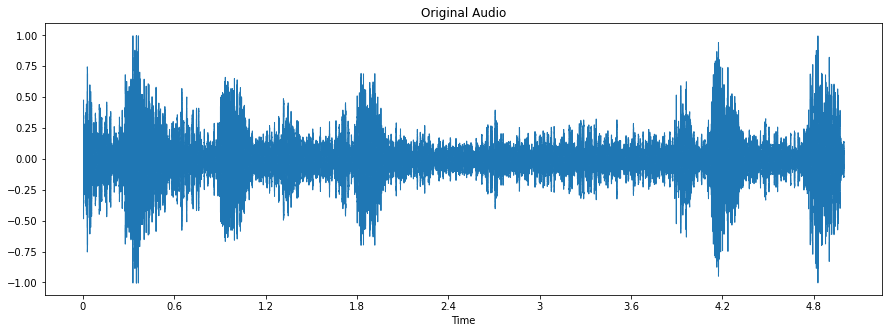

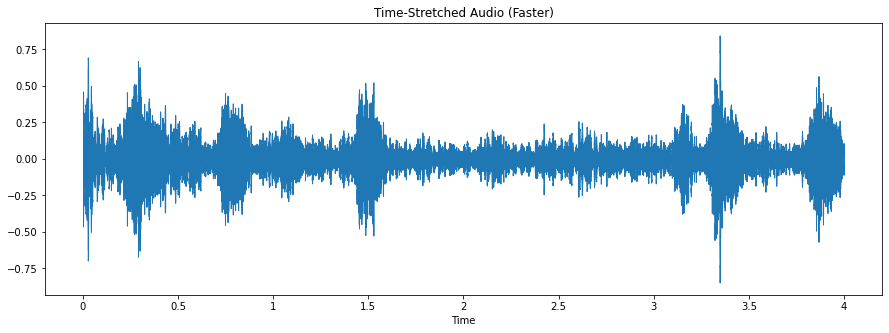

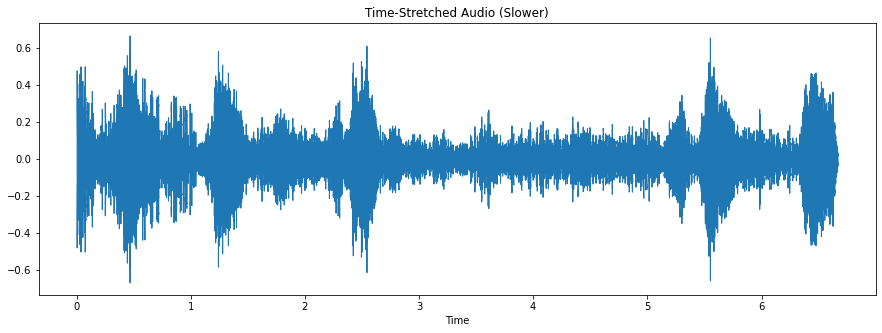

In [15]:
# Randomly extract the content of a file from RDD
# The first parameter indicates whether replacement is allowed, the second parameter is the sample size, and the third parameter is the random seed
random_file = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

# random_file contains the binary content of the randomly selected file
y, sr = librosa.load(io.BytesIO(random_file), sr=None)

# Time Stretching: Speed up by 1.25x and slow down by 0.75x
y_fast = librosa.effects.time_stretch(y, rate=1.25)
y_slow = librosa.effects.time_stretch(y, rate=0.75)

# Original
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Original Audio')
plt.show()

# Fast
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_fast, sr=sr)
plt.title('Time-Stretched Audio (Faster)')
plt.show()

# Slow
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_slow, sr=sr)
plt.title('Time-Stretched Audio (Slower)')
plt.show()


### (2) Pitch shifting

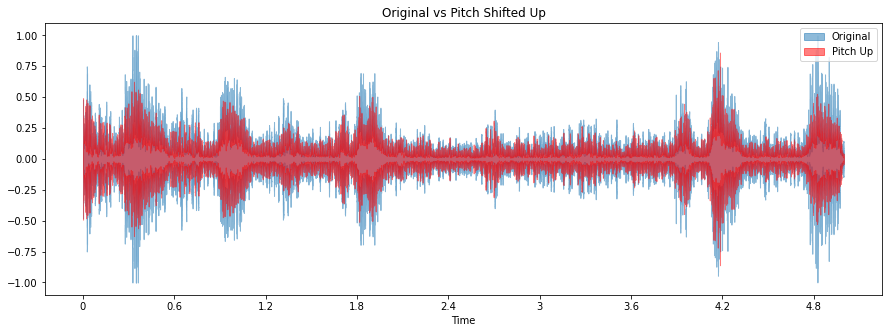

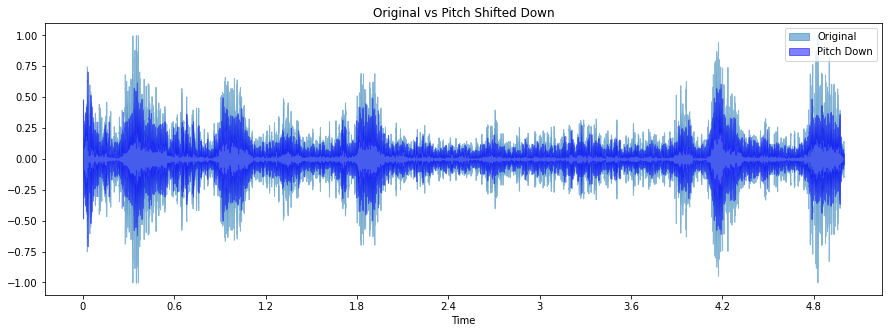

In [16]:
# Randomly extract the content of a file from RDD
random_file_content = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

# Load the audio file from binary content
y, sr = librosa.load(io.BytesIO(random_file_content), sr=None)

# Apply pitch shifting: Raise by two semitones
y_pitch_up = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=3)

# Apply pitch shifting: Lower by two semitones
y_pitch_down = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-3)

# Plot the original audio and the pitch shifted versions (up and down)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_pitch_up, sr=sr, color='r', alpha=0.5, label='Pitch Up')
plt.legend()
plt.title('Original vs Pitch Shifted Up')
plt.show()

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_pitch_down, sr=sr, color='b', alpha=0.5, label='Pitch Down')
plt.legend()
plt.title('Original vs Pitch Shifted Down')
plt.show()


### (3) Volume scaling

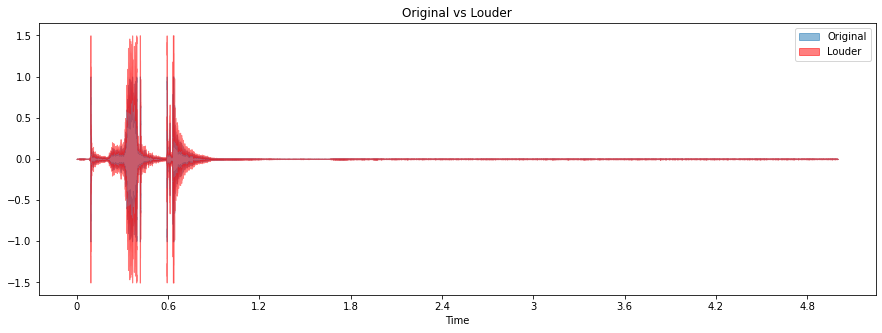

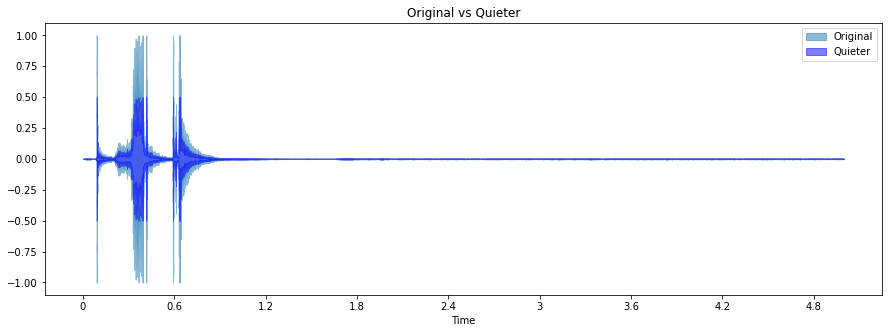

In [17]:
random_file_content = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

# Load the audio file from binary content
y, sr = librosa.load(io.BytesIO(random_file_content), sr=None)

# Adjust volume: Make it louder and quieter
y_louder = y * 1.5  # Increase volume
y_quieter = y * 0.5  # Decrease volume

# Plot the original audio and the louder version
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_louder, sr=sr, color='r', alpha=0.5, label='Louder')
plt.legend()
plt.title('Original vs Louder')
plt.show()

# Plot the original audio and the quieter version
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_quieter, sr=sr, color='b', alpha=0.5, label='Quieter')
plt.legend()
plt.title('Original vs Quieter')
plt.show()


### (4) Add noise

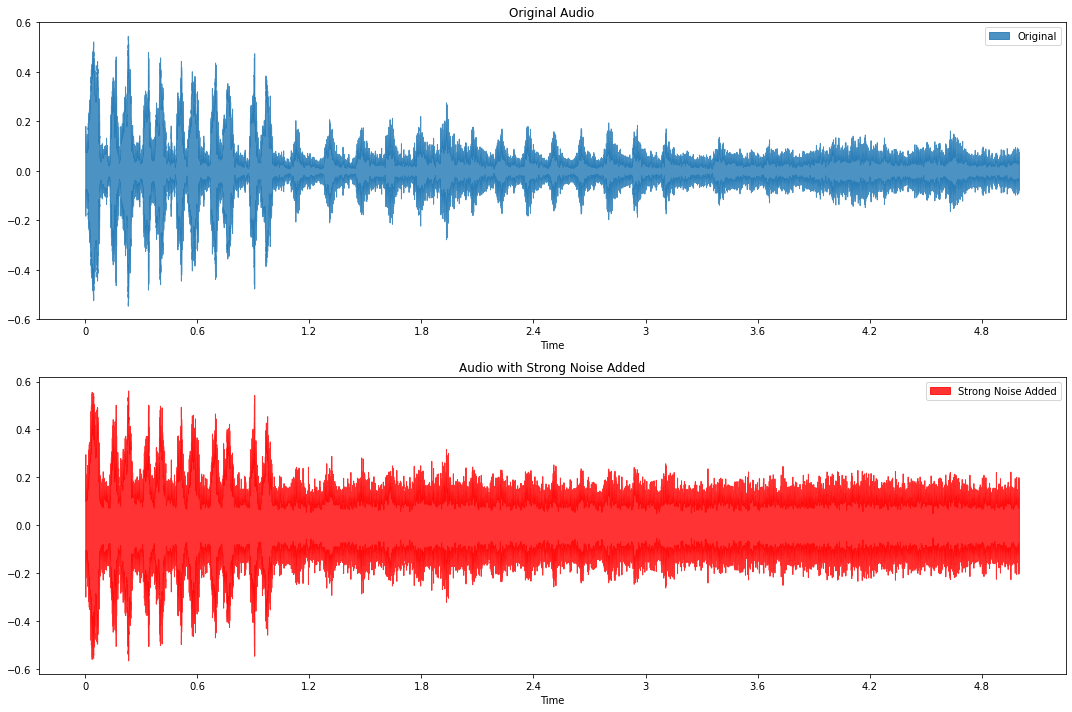

In [18]:
random_file_content = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

y, sr = librosa.load(io.BytesIO(random_file_content), sr=None)

# Add noise
noise_level = 0.05  
noise = np.random.randn(len(y))
y_noise_strong = y + noise_level * noise  

plt.figure(figsize=(15, 10))

# Plot the original audio waveform
plt.subplot(2, 1, 1)  
librosa.display.waveshow(y, sr=sr, alpha=0.8, label='Original')
plt.legend()
plt.title('Original Audio')

# Plot the audio waveform with strong noise added
plt.subplot(2, 1, 2)  
librosa.display.waveshow(y_noise_strong, sr=sr, alpha=0.8, color='r', label='Strong Noise Added')
plt.legend()
plt.title('Audio with Strong Noise Added')

plt.tight_layout() 
plt.show()


### (5) Time shifting

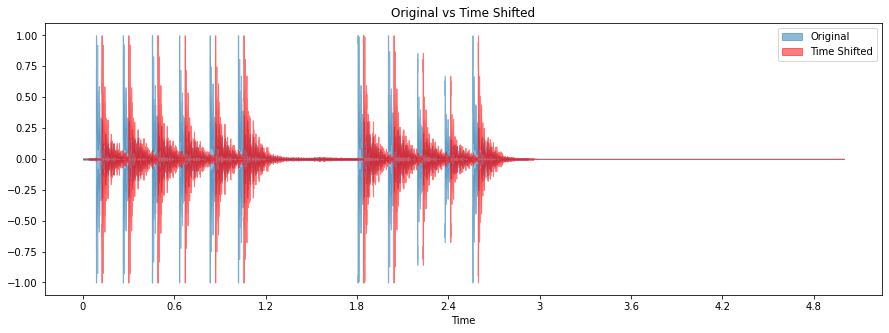

In [19]:

random_file_content = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

y, sr = librosa.load(io.BytesIO(random_file_content), sr=None)

# Time shifting the audio
shift_amount = 1600 
y_shifted = np.roll(y, shift=shift_amount)

# Plot the original audio and the time-shifted version
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_shifted, sr=sr, color='r', alpha=0.5, label='Time Shifted')
plt.legend()
plt.title('Original vs Time Shifted')
plt.show()


### (6) Echo

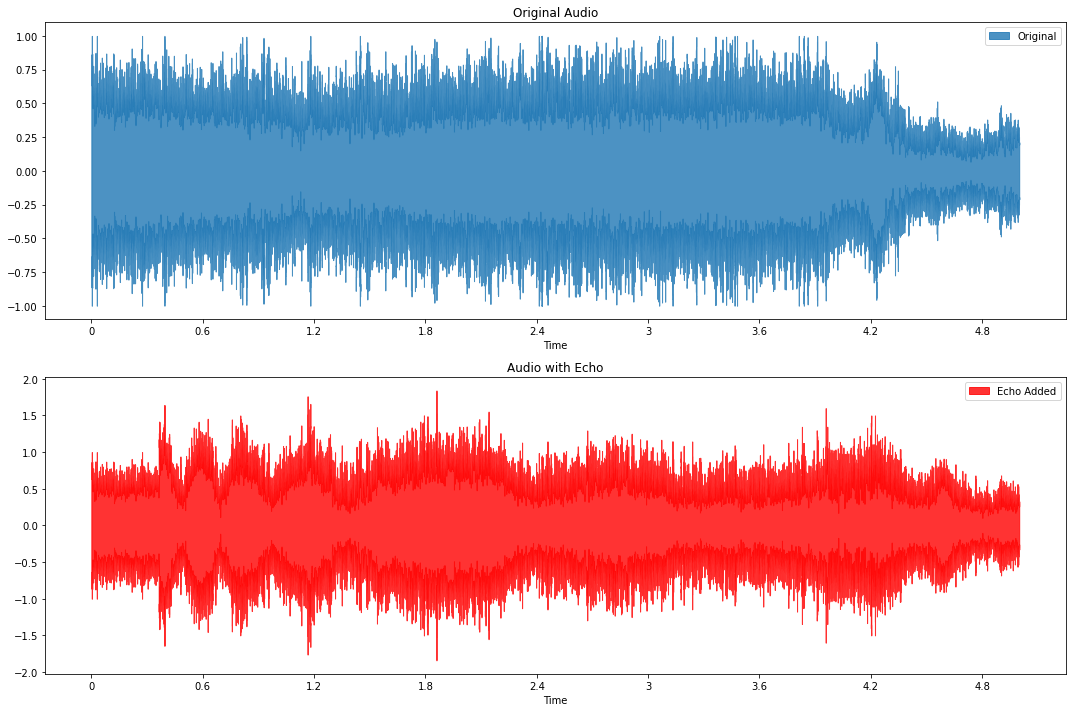

In [20]:
random_file_content = limited_files_rdd.takeSample(False, 1, seed=None)[0][1]

y, sr = librosa.load(io.BytesIO(random_file_content), sr=None)

# Add echo effect
echo_delay = 16000  # Delay in samples for the echo
# Pad the original audio with silence at the beginning to create the delay
echo_signal = np.pad(y, (echo_delay, 0), mode='constant')

# To ensure the lengths of the two signals are consistent, the echo signal needs to be truncated
echo_signal = echo_signal[:len(y)]

# Create the audio with echo by adding the original audio and the delayed signal
echo = y + echo_signal

# Plot the original audio waveform and the audio waveform with echo effect for comparison
plt.figure(figsize=(15, 10))

# Plot the original audio waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.8, label='Original')
plt.legend()
plt.title('Original Audio')

# Plot the audio waveform with echo effect
plt.subplot(2, 1, 2)
librosa.display.waveshow(echo, sr=sr, alpha=0.8, color='r', label='Echo Added')
plt.legend()
plt.title('Audio with Echo')

plt.tight_layout()
plt.show()


In [21]:
spark.stop()

#  Preprocessing with Spark for Deep Learning

In [22]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("AudioProcessing") \
    .config("spark.master", "local[8]") \
    .getOrCreate()

# Set the directory containing audio files
data = "/user1/audio"

# List of interested categories
selected_categories = ['0', '1', '2', '3', '4']

# Read all binary files in the directory
files_rdd = spark.sparkContext.binaryFiles(data)

# Define a function to add white noise
def add_white_noise(audio, noise_level=0.005):
    wn = np.random.randn(len(audio))
    audio_wn = audio + noise_level * wn
    return audio_wn

# Define a function to change playback speed
def change_speed(audio, speed_factor):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

# Define a function to resize spectrogram
def resize_spectrogram(spectrogram, target_shape):
    delta_row = target_shape[0] - spectrogram.shape[0]
    delta_col = target_shape[1] - spectrogram.shape[1]
    if delta_row > 0 or delta_col > 0:
        padding = ((0, max(0, delta_row)), (0, max(0, delta_col)))
        spectrogram = np.pad(spectrogram, pad_width=padding, mode='constant')
    else:
        spectrogram = spectrogram[:target_shape[0], :target_shape[1]]
    return spectrogram

# Define a function to process each audio file and extract features
def process_and_extract_features(file_data):
    file_path, file_content = file_data
    category_label = file_path.split("/")[-1].split("-")[-1].replace(".wav", "")
    if category_label in selected_categories:
        audio, sample_rate = librosa.load(io.BytesIO(file_content), sr=None)
        audio_wn = add_white_noise(audio)
        audio_changed = change_speed(audio_wn, np.random.uniform(0.8, 1.2))
        S = librosa.feature.melspectrogram(y=audio_changed, sr=sample_rate)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return (S_DB, category_label)
    else:
        return None

# Apply process_and_extract_features to each file and remove None items
spectrograms_and_labels = files_rdd.map(process_and_extract_features).filter(lambda x: x is not None)

# Collect the sizes of all spectrograms to determine the maximum size
max_shape = spectrograms_and_labels.map(lambda x: x[0].shape).reduce(lambda a, b: (max(a[0], b[0]), max(a[1], b[1])))

# Resize all spectrograms to the maximum size
resized_spectrograms_and_labels = spectrograms_and_labels.map(lambda x: (resize_spectrogram(x[0], max_shape), x[1]))
spectrograms_and_labels = resized_spectrograms_and_labels.collect()  


In [23]:
spark.stop()

In [24]:
# Get all string labels
labels = [x[1] for x in spectrograms_and_labels]

# Convert string labels to integer labels
def label_to_int(label):
    return int(label)

int_labels = [label_to_int(label) for label in labels]

# Replace the original string labels with integer labels
spectrograms_and_labels = [(x[0], int_labels[i]) for i, x in enumerate(spectrograms_and_labels)]


In [25]:
max_length = max(len(audio) for audio, _ in spectrograms_and_labels)
for i, (audio, label) in enumerate(spectrograms_and_labels):
    if len(audio) < max_length:
        spectrograms_and_labels[i] = (np.pad(audio, (0, max_length - len(audio))), label)
    elif len(audio) > max_length:
        spectrograms_and_labels[i] = (audio[:max_length], label)


max_shape = max(S_DB.shape for S_DB, _ in spectrograms_and_labels)
for i, (S_DB, label) in enumerate(spectrograms_and_labels):
    if S_DB.shape != max_shape:
        new_shape = (max_shape[0], max_shape[1])
        spectrograms_and_labels[i] = (np.pad(S_DB, ((0, max_shape[0] - S_DB.shape[0]), (0, max_shape[1] - S_DB.shape[1]))), label)

In [26]:
# Get the shape of the first mel spectrogram
first_spectrogram_shape = spectrograms_and_labels[0][0].shape
first_spectrogram_shape


(128, 526)

In [27]:
for spectrogram, label in spectrograms_and_labels:
    if spectrogram.shape != first_spectrogram_shape:
        print("Spectrogram shapes are not consistent!")
        break
else:
    print("All spectrograms have consistent shapes:", first_spectrogram_shape)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape spectrogram data to a shape suitable for MinMaxScaler
scaled_spectrograms = []

for spectrogram, label in spectrograms_and_labels:
    scaled_spectrogram = scaler.fit_transform(spectrogram)

    # Reshape the scaled spectrogram (if necessary) back to its original shape, here we keep it in 2D shape
    scaled_spectrograms.append((scaled_spectrogram, label))

X = np.array([item[0] for item in scaled_spectrograms])  # Convert to np.ndarray
y = np.array([item[1] for item in scaled_spectrograms])  # Convert to np.ndarray

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


All spectrograms have consistent shapes: (128, 526)


In [28]:


# L2 regularization coefficient
l2_reg = 0.001

num_classes = 5

model = Sequential([
    Bidirectional(GRU(16, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(GRU(32, kernel_regularizer=l2(l2_reg))),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Start timing
start_time = time.time()

# Train the model using the fit method
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

# End timing
end_time = time.time()

# Calculate training time (in minutes)
training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", training_time_minutes)

# Evaluate the model using the evaluate method
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 32)        │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,021 (257.89 KB)

 Trainable params: 66,021 (257.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.2720 - loss: 1.9182 - val_accuracy: 0.3750 - val_loss: 1.8004
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.3432 - loss: 1.8115 - val_accuracy: 0.4250 - val_loss: 1.7608
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3864 - loss: 1.7675 - val_accuracy: 0.2750 - val_loss: 1.7175
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3978 - loss: 1.7286 - val_accuracy: 0.5250 - val_loss: 1.6797
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4471 - loss: 1.7087 - val_accuracy: 0.4250 - val_loss: 1.6595
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4300 - loss: 1.6105 - val_accuracy: 0.4500 - val_loss: 1.6159
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4191 - loss: 1.6075 - val_accuracy: 0.5250 - val_loss: 1.5655
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4733 - loss: 1.5347 - val_accuracy: 0.4250 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5437 - loss: 2.4488
Test accuracy: 0.5500


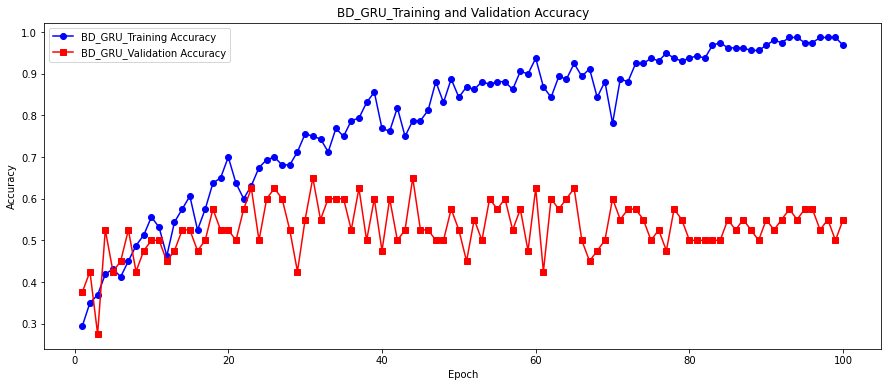

In [29]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='BD_GRU_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='BD_GRU_Validation Accuracy')
plt.title('BD_GRU_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Model Comparison Based on Mel Spectrogram Feature Extraction Data

In [30]:

def add_white_noise(audio, noise_level=0.005):
    wn = np.random.randn(len(audio))
    audio_wn = audio + noise_level * wn
    return audio_wn

def change_speed(audio, speed_factor):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

def pitch_shift(audio, pitch_factor):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_factor)

def time_shift(audio, shift_factor):
    shift_samples = int(shift_factor * sample_rate)
    return np.roll(audio, shift_samples)

def add_echo(audio, delay_factor, decay=0.5):
    delay_samples = int(delay_factor * sample_rate)
    delayed_audio = np.zeros_like(audio)
    delayed_audio[delay_samples:] = audio[:-delay_samples] * decay
    return audio + delayed_audio

def volume_scaling(audio, scaling_factor):
    return audio * scaling_factor

directory_path = "/home/hduser/Downloads/ESC/audio"
selected_categories = [0,1,2,3,4]
spectrograms_and_labels = []

for filename in os.listdir(directory_path):
    category_label = int(filename.split("-")[-1].replace(".wav", ""))
    if category_label in selected_categories:
        file_path = os.path.join(directory_path, filename)
        audio, sample_rate = librosa.load(file_path)
        
        # Original sample
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        spectrograms_and_labels.append((spectrogram_db, category_label))
        
        # Augmented samples
        for _ in range(4):  # Generating 4 augmented samples
            augmented_audio = audio.copy()
            augmented_audio = add_white_noise(augmented_audio)
            augmented_audio = change_speed(augmented_audio, np.random.uniform(0.8, 1.2))
            augmented_audio = pitch_shift(augmented_audio, np.random.randint(-3, 4))  # Random pitch shift within [-3, 3]
            augmented_audio = time_shift(augmented_audio, np.random.uniform(-0.5, 0.5))  # Random time shift within [-0.5, 0.5]
            augmented_audio = add_echo(augmented_audio, np.random.uniform(0.1, 0.5))  # Randomly add echo within [0.1, 0.5]
            augmented_audio = volume_scaling(augmented_audio, np.random.uniform(0.5, 1.5))  # Random volume scaling
            
            augmented_spectrogram = librosa.feature.melspectrogram(y=augmented_audio, sr=sample_rate)
            augmented_spectrogram_db = librosa.power_to_db(augmented_spectrogram, ref=np.max)
            spectrograms_and_labels.append((augmented_spectrogram_db, category_label))

# Number of samples after augmentation
print("Number of samples after augmentation:", len(spectrograms_and_labels))


Number of samples after augmentation: 1000


In [31]:
max_length = max(len(audio) for audio, _ in spectrograms_and_labels)
for i, (audio, label) in enumerate(spectrograms_and_labels):
    if len(audio) < max_length:
        spectrograms_and_labels[i] = (np.pad(audio, (0, max_length - len(audio))), label)
    elif len(audio) > max_length:
        spectrograms_and_labels[i] = (audio[:max_length], label)


max_shape = max(S_DB.shape for S_DB, _ in spectrograms_and_labels)
for i, (S_DB, label) in enumerate(spectrograms_and_labels):
    if S_DB.shape != max_shape:
        new_shape = (max_shape[0], max_shape[1])
        spectrograms_and_labels[i] = (np.pad(S_DB, ((0, max_shape[0] - S_DB.shape[0]), (0, max_shape[1] - S_DB.shape[1]))), label)


# Get the shape of the first mel spectrogram
first_spectrogram_shape = spectrograms_and_labels[0][0].shape

# Traverse to check shapes of all mel spectrograms
for spectrogram, label in spectrograms_and_labels:
    if spectrogram.shape != first_spectrogram_shape:
        print("Spectrogram shapes are not consistent!")
        break
else:
    print("All spectrograms have consistent shapes:", first_spectrogram_shape)


All spectrograms have consistent shapes: (128, 270)


In [32]:

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_spectrograms1 = []

for spectrogram, label in spectrograms_and_labels:
    # Reshape the spectrogram data to 2D ('spectrogram.shape[0]' is the number of frequency bins, '-1' means automatically calculate the number of time frames)
    spectrogram_2d = spectrogram.reshape(spectrogram.shape[0], -1)
    
    scaled_spectrogram = scaler.fit_transform(spectrogram_2d)
    
    # Restore the scaled spectrogram to its original 3D shape (if needed), or keep it in 2D shape for further processing
    
    scaled_spectrograms1.append((scaled_spectrogram, label))

# Now, scaled_spectrograms1 contains the scaled spectrograms and their corresponding labels


In [33]:
scaled_spectrograms1_reshaped = []

for scaled_spectrogram, label in scaled_spectrograms1:
    # Add a new dimension representing the number of channels as 1
    scaled_spectrogram = scaled_spectrogram[:, :, np.newaxis]
    scaled_spectrograms1_reshaped.append((scaled_spectrogram, label))


In [34]:


X = np.array([item[0] for item in scaled_spectrograms1_reshaped])  # 转换为np.ndarray
y = np.array([item[1] for item in scaled_spectrograms1_reshaped])  # 转换为np.ndarray

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [35]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolutional layer with fewer filters
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second convolutional layer with more filters
        layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layer
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Here, 1 represents the spectrogram is single-channel
num_classes = 5  

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

start_time = time.time()

# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

# Calculate training time (in minutes)
CNN_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", CNN_training_time_minutes)

# Evaluate the model
CNN_test_loss, CNN_test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", CNN_test_accuracy)


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 268, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 268, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 134, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 134, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 132, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 132, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │     1,013,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,018,917 (3.89 MB)

 Trainable params: 1,018,789 (3.89 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 546ms/step - accuracy: 0.3945 - loss: 1.5371 - val_accuracy: 0.4650 - val_loss: 1.6839
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.6777 - loss: 1.0209 - val_accuracy: 0.2000 - val_loss: 2.1230
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.7758 - loss: 0.8059 - val_accuracy: 0.1900 - val_loss: 2.1283
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - accuracy: 0.8588 - loss: 0.6288 - val_accuracy: 0.3600 - val_loss: 1.9486
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.9044 - loss: 0.4980 - val_accuracy: 0.3600 - val_loss: 2.0249
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.9364 - loss: 0.4039 - val_accuracy: 0.2350 - val_loss: 2.0054
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.9533 - loss: 0.3606 - val_accuracy: 0.2350 - val_loss: 2.0336
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - accuracy: 0.9748 - loss: 0.3102 - 

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.9953 - loss: 0.1760 - val_accuracy: 0.9050 - val_loss: 0.5476
Epoch 100/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.9967 - loss: 0.1609 - val_accuracy: 0.8950 - val_loss: 0.5562
Training time (minutes): 21.734254280726116
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8777 - loss: 0.5846
Test Accuracy: 0.8949999809265137


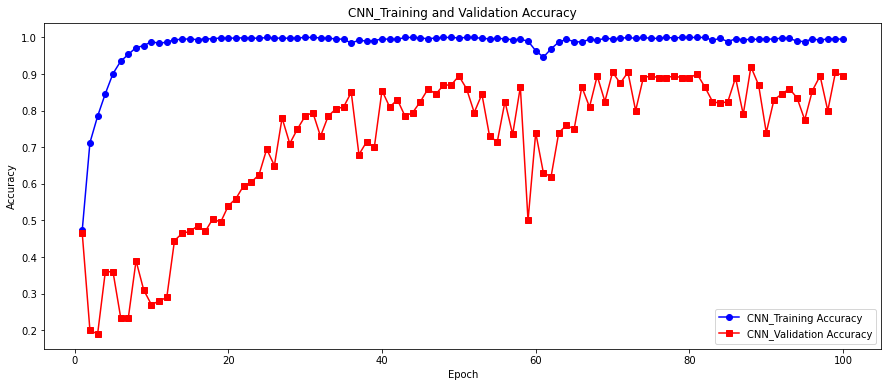

In [36]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='CNN_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='CNN_Validation Accuracy')
plt.title('CNN_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [37]:


def create_rcnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional layers for feature extraction
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape,
                      padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Reshape the output of Conv2D layers to fit the RNN layers
        layers.Reshape((-1, 32)),  # Adjust this parameter based on your actual scenario
        
        # Recurrent layers for processing temporal sequence information
        layers.Bidirectional(layers.LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.001))),
        layers.Dropout(0.3),
        
        # Fully connected and output layers
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Assuming input shape is (samples, time_steps, height, width, channels)
# Here, input shape should match the shape of video frames or time-series images
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # None represents variable time steps
num_classes = 5  

model = create_rcnn_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

start_time = time.time()

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

CRNN_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", CRNN_training_time_minutes)

CRNN_test_loss, CRNN_test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", CRNN_test_accuracy)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 270, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 270, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 135, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 135, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 135, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 135, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 67, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 67, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2144, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,429 (44.64 KB)

 Trainable params: 11,333 (44.27 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2216 - loss: 1.7896 - val_accuracy: 0.2200 - val_loss: 1.7038
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2574 - loss: 1.6769 - val_accuracy: 0.2400 - val_loss: 1.6935
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3379 - loss: 1.6093 - val_accuracy: 0.3800 - val_loss: 1.6794
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3964 - loss: 1.5482 - val_accuracy: 0.3400 - val_loss: 1.6692
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4184 - loss: 1.5224 - val_accuracy: 0.4000 - val_loss: 1.6586
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4758 - loss: 1.4276 - val_accuracy: 0.3300 - val_loss: 1.6408
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4807 - loss: 1.3867 - val_accuracy: 0.3550 - val_loss: 1.6281
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5199 - loss: 1.3465 - val_accuracy: 0.3500 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7796 - loss: 0.7760
Test Accuracy: 0.7900000214576721


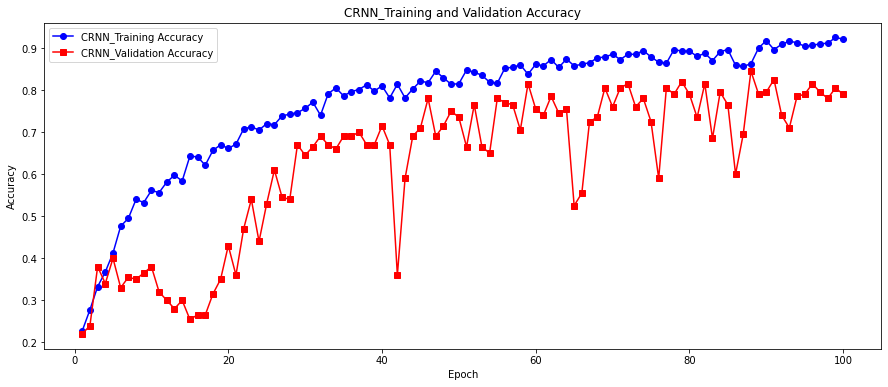

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='CRNN_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='CRNN_Validation Accuracy')
plt.title('CRNN_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [39]:
del scaled_spectrograms1
del scaled_spectrograms1_reshaped

In [40]:
max_length = max(len(audio) for audio, _ in spectrograms_and_labels)
for i, (audio, label) in enumerate(spectrograms_and_labels):
    if len(audio) < max_length:
        spectrograms_and_labels[i] = (np.pad(audio, (0, max_length - len(audio))), label)
    elif len(audio) > max_length:
        spectrograms_and_labels[i] = (audio[:max_length], label)


max_shape = max(S_DB.shape for S_DB, _ in spectrograms_and_labels)
for i, (S_DB, label) in enumerate(spectrograms_and_labels):
    if S_DB.shape != max_shape:
        new_shape = (max_shape[0], max_shape[1])
        spectrograms_and_labels[i] = (np.pad(S_DB, ((0, max_shape[0] - S_DB.shape[0]), (0, max_shape[1] - S_DB.shape[1]))), label)



first_spectrogram_shape = spectrograms_and_labels[0][0].shape

for spectrogram, label in spectrograms_and_labels:
    if spectrogram.shape != first_spectrogram_shape:
        print("Spectrogram shapes are not consistent!")
        break
else:
    print("All spectrograms have consistent shapes:", first_spectrogram_shape)
from sklearn.preprocessing import MinMaxScaler
import numpy as np


scaler = MinMaxScaler(feature_range=(0, 1))


scaled_spectrograms = []

for spectrogram, label in spectrograms_and_labels:
    
    scaled_spectrogram = scaler.fit_transform(spectrogram)
    
    
    
    scaled_spectrograms.append((scaled_spectrogram, label))


All spectrograms have consistent shapes: (128, 270)


In [41]:


X = np.array([item[0] for item in scaled_spectrograms])  # 转换为np.ndarray
y = np.array([item[1] for item in scaled_spectrograms])  # 转换为np.ndarray

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [42]:


l2_reg = 0.001

model = Sequential([
    LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()

history_complex_l2 = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

LSTM_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", LSTM_training_time_minutes)

LSTM_test_loss,LSTM_test_accuracy = model.evaluate(test_dataset)
print("Test accuracy:",LSTM_test_accuracy)


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128, 16)        │        18,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,253 (98.64 KB)

 Trainable params: 25,253 (98.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.1952 - loss: 1.7659 - val_accuracy: 0.1850 - val_loss: 1.7367
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2369 - loss: 1.7241 - val_accuracy: 0.3350 - val_loss: 1.6577
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2858 - loss: 1.6851 - val_accuracy: 0.3600 - val_loss: 1.5829
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3144 - loss: 1.6146 - val_accuracy: 0.3950 - val_loss: 1.5603
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3315 - loss: 1.5884 - val_accuracy: 0.3750 - val_loss: 1.5269
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3706 - loss: 1.5482 - val_accuracy: 0.3750 - val_loss: 1.5059
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3279 - loss: 1.5746 - val_accuracy: 0.4100 - val_loss: 1.4868
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3688 - loss: 1.4843 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6843 - loss: 1.0166
Test accuracy: 0.6700000166893005


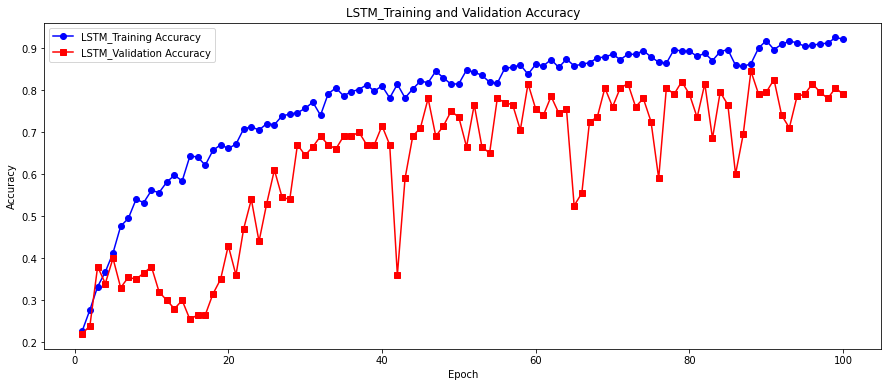

In [43]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='LSTM_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='LSTM_Validation Accuracy')
plt.title('LSTM_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [44]:


l2_reg = 0.001

num_classes = 5

model = Sequential([
    Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(l2_reg))),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()


history_complex_l2 = model.fit(train_dataset, epochs=100, validation_data=test_dataset)


end_time = time.time()


BD_LSTM_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", BD_LSTM_training_time_minutes)


BD_LSTM_test_loss, BD_LSTM_test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {BD_LSTM_test_accuracy:.4f}")


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 128, 32)        │        36,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,501 (212.89 KB)

 Trainable params: 54,501 (212.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.2166 - loss: 1.9570 - val_accuracy: 0.2150 - val_loss: 1.9065
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.2155 - loss: 1.8998 - val_accuracy: 0.3300 - val_loss: 1.8445
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.2352 - loss: 1.8522 - val_accuracy: 0.3850 - val_loss: 1.7483
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.3120 - loss: 1.7526 - val_accuracy: 0.4150 - val_loss: 1.7010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.3388 - loss: 1.7231 - val_accuracy: 0.4200 - val_loss: 1.5593
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4187 - loss: 1.5995 - val_accuracy: 0.5050 - val_loss: 1.5263
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4679 - loss: 1.5122 - val_accuracy: 0.5450 - val_loss: 1.3890
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.4980 - loss: 1.4581 - val_accuracy: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8443 - loss: 0.6506
Test accuracy: 0.8300


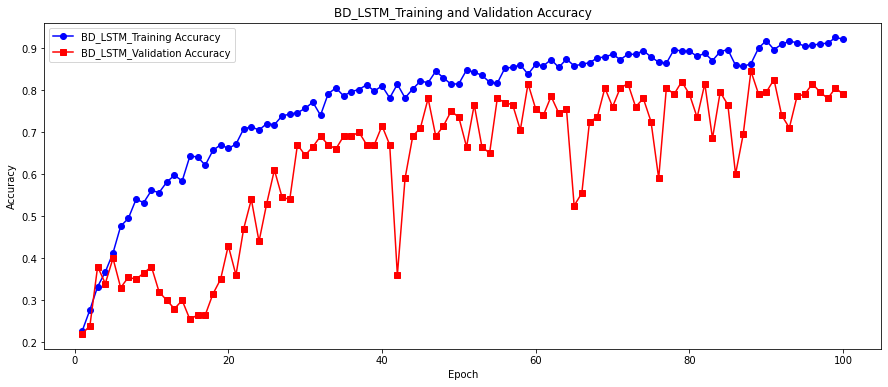

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='BD_LSTM_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='BD_LSTM_Validation Accuracy')
plt.title('BD_LSTM_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [46]:



l2_reg = 0.001


num_classes = 5


model = Sequential([
    Bidirectional(GRU(16, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(32, kernel_regularizer=l2(l2_reg))),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

start_time = time.time()


history = model.fit(train_dataset, validation_data=test_dataset, epochs=100)


end_time = time.time()


BD_GRU_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", BD_GRU_training_time_minutes)


BD_GRU_test_loss, BD_GRU_test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {BD_GRU_test_accuracy:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 128, 32)        │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,445 (161.89 KB)

 Trainable params: 41,445 (161.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.1995 - loss: 1.9324 - val_accuracy: 0.2900 - val_loss: 1.8307
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.2477 - loss: 1.8210 - val_accuracy: 0.2250 - val_loss: 1.7877
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.2377 - loss: 1.7821 - val_accuracy: 0.2850 - val_loss: 1.7419
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.3146 - loss: 1.7168 - val_accuracy: 0.2600 - val_loss: 1.6887
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.2985 - loss: 1.6916 - val_accuracy: 0.3600 - val_loss: 1.6425
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.3683 - loss: 1.6394 - val_accuracy: 0.3900 - val_loss: 1.6009
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.3386 - loss: 1.6297 - val_accuracy: 0.5000 - val_loss: 1.5206
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.3960 - loss: 1.5421 - val_acc

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8225 - loss: 0.6433 - val_accuracy: 0.7350 - val_loss: 0.8727
Epoch 52/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8603 - loss: 0.5026 - val_accuracy: 0.7500 - val_loss: 0.7679
Epoch 53/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8662 - loss: 0.5356 - val_accuracy: 0.6950 - val_loss: 0.9137
Epoch 54/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7971 - loss: 0.6896 - val_accuracy: 0.7250 - val_loss: 0.7717
Epoch 55/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8357 - loss: 0.5632 - val_accuracy: 0.7500 - val_loss: 0.7832
Epoch 56/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8479 - loss: 0.5082 - val_accuracy: 0.6700 - val_loss: 1.0010
Epoch 57/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8271 - loss: 0.5856 - val_accuracy: 0.7700 - val_loss: 0.7366
Epoch 58/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8776 - loss: 0.4948 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7639 - loss: 0.8600
Test accuracy: 0.7750


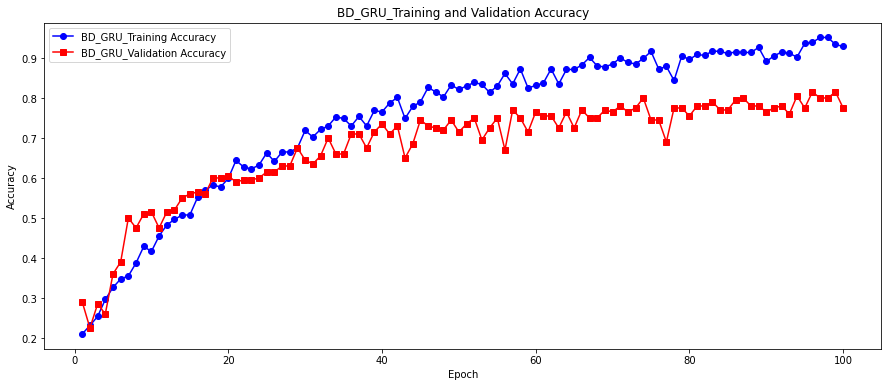

In [47]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='BD_GRU_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='BD_GRU_Validation Accuracy')
plt.title('BD_GRU_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


/tmp/ipykernel_3823/3124952762.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  accuracy_bars = sns.barplot(x='Value', y='Model', data=accuracy_data, ax=axes[0], palette='coolwarm')
/tmp/ipykernel_3823/3124952762.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  time_bars = sns.barplot(x='Value', y='Model', data=time_data, ax=axes[1], palette='viridis')


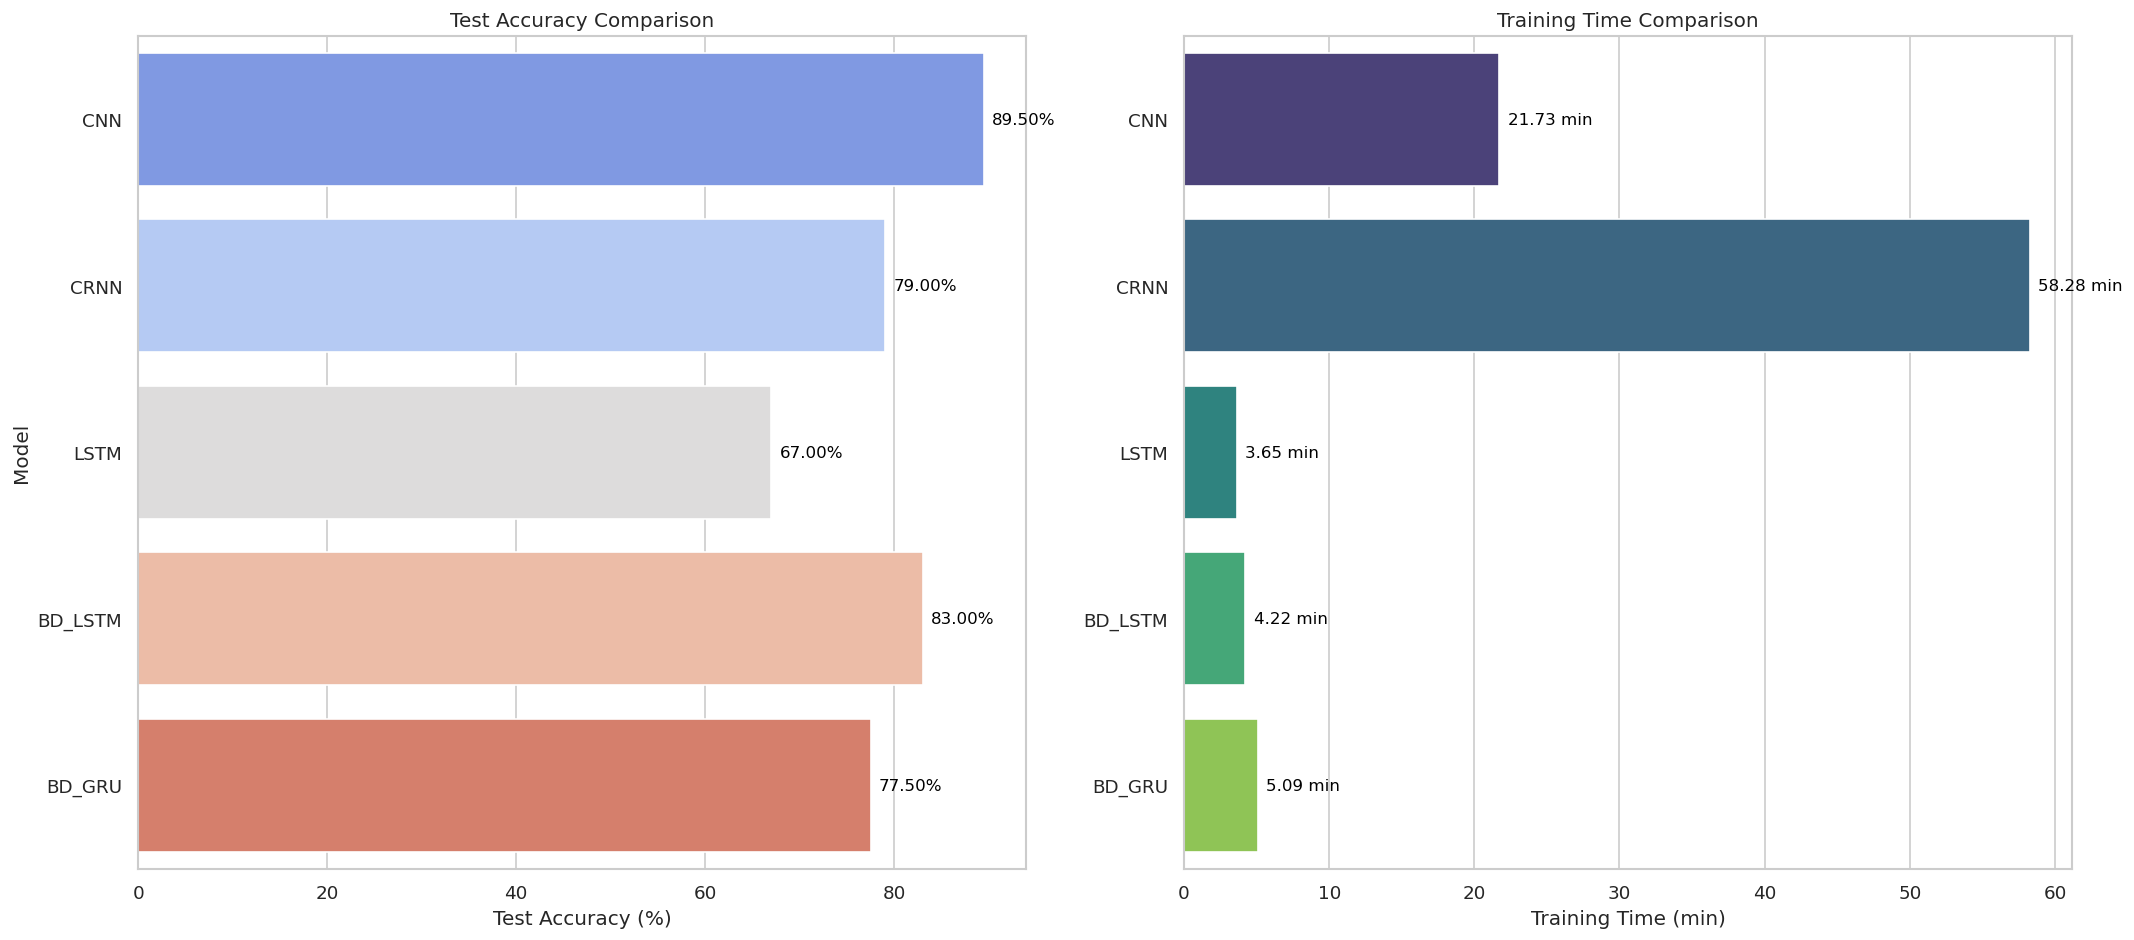

In [48]:
# Model names
models = ['CNN', 'CRNN', 'LSTM', 'BD_LSTM', 'BD_GRU']

# Training time and test accuracy data
training_times = [CNN_training_time_minutes, CRNN_training_time_minutes, LSTM_training_time_minutes, BD_LSTM_training_time_minutes, BD_GRU_training_time_minutes]
test_accuracies = [CNN_test_accuracy, CRNN_test_accuracy, LSTM_test_accuracy, BD_LSTM_test_accuracy, BD_GRU_test_accuracy]

# Prepare data for test accuracy and training time separately
accuracy_data = pd.DataFrame({
    'Model': models,
    'Value': [x * 100 for x in test_accuracies],  # Convert to percentage
    'Type': 'Test Accuracy (%)'
})

time_data = pd.DataFrame({
    'Model': models,
    'Value': training_times,
    'Type': 'Training Time (min)'
})

# Set the plot style
sns.set(style="whitegrid")

# Create subplots for test accuracy and training time comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=120)

# Test accuracy plot with values
accuracy_bars = sns.barplot(x='Value', y='Model', data=accuracy_data, ax=axes[0], palette='coolwarm')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_xlabel('Test Accuracy (%)')
axes[0].set_ylabel('Model')
# Add value labels outside the bars
for p in accuracy_bars.patches:
    axes[0].annotate(f'{p.get_width():.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

# Training time plot with values
time_bars = sns.barplot(x='Value', y='Model', data=time_data, ax=axes[1], palette='viridis')
axes[1].set_title('Training Time Comparison')
axes[1].set_xlabel('Training Time (min)')
axes[1].set_ylabel('')
# Add value labels outside the bars, precise to two decimal places
for p in time_bars.patches:
    axes[1].annotate(f'{p.get_width():.2f} min', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()


# Model Comparison Based on Mel-Frequency Cepstral Coefficients (MFCCs) Feature Extraction Data"

In [49]:


def add_white_noise(audio, noise_level=0.005):
    wn = np.random.randn(len(audio))
    audio_wn = audio + noise_level * wn
    return audio_wn

def change_speed(audio, speed_factor):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

def pitch_shift(audio, pitch_factor, sample_rate):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_factor)

def time_shift(audio, shift_factor, sample_rate):
    shift_samples = int(shift_factor * sample_rate)
    return np.roll(audio, shift_samples)

def add_echo(audio, delay_factor, sample_rate, decay=0.5):
    delay_samples = int(delay_factor * sample_rate)
    delayed_audio = np.zeros_like(audio)
    delayed_audio[delay_samples:] = audio[:-delay_samples] * decay
    return audio + delayed_audio

def volume_scaling(audio, scaling_factor):
    return audio * scaling_factor

directory_path = "/home/hduser/Downloads/ESC/audio"
selected_categories = [0, 1, 2, 3, 4]
spectrograms_and_labels = []

for filename in os.listdir(directory_path):
    category_label = int(filename.split("-")[-1].replace(".wav", ""))
    if category_label in selected_categories:
        file_path = os.path.join(directory_path, filename)
        audio, sample_rate = librosa.load(file_path)
        
        # Original sample's MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
        spectrograms_and_labels.append((mfcc, category_label))
        
        # Augmented samples
        for _ in range(4):  # Generate 4 augmented samples
            augmented_audio = audio.copy()
            augmented_audio = add_white_noise(augmented_audio)
            augmented_audio = change_speed(augmented_audio, np.random.uniform(0.8, 1.2))
            augmented_audio = pitch_shift(augmented_audio, np.random.randint(-3, 4), sample_rate)  # Random pitch shift within the range [-3, 3]
            augmented_audio = time_shift(augmented_audio, np.random.uniform(-0.5, 0.5), sample_rate)  # Random time shift within the range [-0.5, 0.5]
            augmented_audio = add_echo(augmented_audio, np.random.uniform(0.1, 0.5), sample_rate)  # Randomly add echo within the range [0.1, 0.5]
            augmented_audio = volume_scaling(augmented_audio, np.random.uniform(0.5, 1.5))  # Random volume scaling
            
            augmented_mfcc = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate)
            spectrograms_and_labels.append((augmented_mfcc, category_label))

# Number of samples after augmentation
print("Number of samples after augmentation:", len(spectrograms_and_labels))


Number of samples after augmentation: 1000


In [50]:
# Find the maximum shape among all features
max_shape = max(feature.shape for feature, _ in spectrograms_and_labels)

# Ensure consistency in shape for each feature
for i, (feature, label) in enumerate(spectrograms_and_labels):
    if feature.shape != max_shape:
        # Calculate the padding needed in both dimensions
        padding = [(0, max_shape[dim] - feature.shape[dim]) for dim in range(2)]
        # Use np.pad for padding, filling extra dimensions with zeros using 'constant' mode
        spectrograms_and_labels[i] = (np.pad(feature, padding, 'constant'), label)


first_feature_shape = spectrograms_and_labels[0][0].shape
consistent_shapes = all(feature.shape == first_feature_shape for feature, _ in spectrograms_and_labels)

if consistent_shapes:
    print("All features have consistent shapes:", first_feature_shape)
else:
    print("Feature shapes are not consistent!")


All features have consistent shapes: (20, 270)


In [51]:


scaler = MinMaxScaler(feature_range=(0, 1))


scaled_spectrograms1 = []

for spectrogram, label in spectrograms_and_labels:
    
    spectrogram_2d = spectrogram.reshape(spectrogram.shape[0], -1)
    
    
    scaled_spectrogram = scaler.fit_transform(spectrogram_2d)
    
    
    
    scaled_spectrograms1.append((scaled_spectrogram, label))



In [52]:
scaled_spectrograms1_reshaped = []

for scaled_spectrogram, label in scaled_spectrograms1:
    
    scaled_spectrogram = scaled_spectrogram[:, :, np.newaxis]
    scaled_spectrograms1_reshaped.append((scaled_spectrogram, label))


In [53]:



X = np.array([item[0] for item in scaled_spectrograms1_reshaped])  # 转换为np.ndarray
y = np.array([item[1] for item in scaled_spectrograms1_reshaped])  # 转换为np.ndarray


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [57]:

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolutional layer with fewer filters
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second convolutional layer with more filters
        layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layer
        layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Here, 1 represents the spectrogram is single-channel
num_classes = 5  

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

start_time = time.time()

# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

# Calculate training time (in minutes)
CNN_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", CNN_training_time_minutes)

# Evaluate the model
CNN_test_loss, CNN_test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", CNN_test_accuracy)


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 18, 268, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 268, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 134, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 9, 134, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 132, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 132, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 66, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 3, 66, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │       101,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,533 (416.14 KB)

 Trainable params: 106,405 (415.64 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3354 - loss: 1.6635 - val_accuracy: 0.2650 - val_loss: 1.6531
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5398 - loss: 1.2163 - val_accuracy: 0.2850 - val_loss: 1.7253
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6687 - loss: 0.9693 - val_accuracy: 0.2200 - val_loss: 1.9466
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7168 - loss: 0.8562 - val_accuracy: 0.2200 - val_loss: 2.8447
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7492 - loss: 0.7704 - val_accuracy: 0.2200 - val_loss: 4.2762
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7625 - loss: 0.7423 - val_accuracy: 0.2200 - val_loss: 5.2692
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8417 - loss: 0.6582 - val_accuracy: 0.2200 - val_loss: 6.1763
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8381 - loss: 0.6063 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8805 - loss: 0.5110
Test Accuracy: 0.8899999856948853


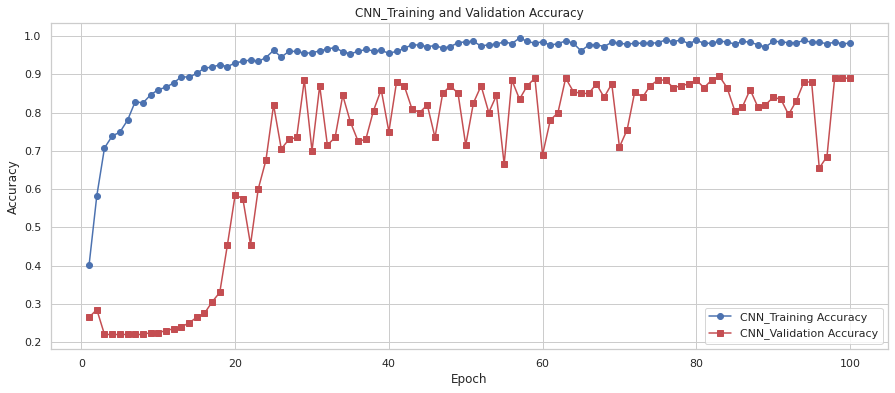

In [58]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)


plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='CNN_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='CNN_Validation Accuracy')
plt.title('CNN_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [59]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
import time

def create_rcnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional layers for feature extraction
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape,
                      padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Reshape the output of Conv2D layers before Flatten layer to fit for RNN layer
        
        layers.Reshape((-1, 32)),  # Adjust parameters here according to the actual situation
        
        # Recurrent layers to process temporal sequence information
        layers.Bidirectional(layers.LSTM(16, return_sequences=False, kernel_regularizer=regularizers.l2(0.001))),
        layers.Dropout(0.3),
        # Fully connected and output layers
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


input_shape = (X_train.shape[1], X_train.shape[2],1)  
num_classes = 5  

model = create_rcnn_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

CRNN_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):",CRNN_training_time_minutes)

CRNN_test_loss, CRNN_test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", CRNN_test_accuracy)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 20, 270, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 20, 270, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 135, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 135, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 135, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 135, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 67, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 67, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 335, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,429 (44.64 KB)

 Trainable params: 11,333 (44.27 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.2203 - loss: 1.7714 - val_accuracy: 0.2100 - val_loss: 1.7083
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.2212 - loss: 1.7274 - val_accuracy: 0.2150 - val_loss: 1.7003
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.2799 - loss: 1.6455 - val_accuracy: 0.3400 - val_loss: 1.6922
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.3022 - loss: 1.5975 - val_accuracy: 0.3450 - val_loss: 1.6809
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.3304 - loss: 1.5770 - val_accuracy: 0.3400 - val_loss: 1.6726
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.3705 - loss: 1.5156 - val_accuracy: 0.3600 - val_loss: 1.6641
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.3918 - loss: 1.4665 - val_accuracy: 0.4050 - val_loss: 1.6401
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.4335 - loss: 1.4304 - val_acc

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8072 - loss: 0.6028 - val_accuracy: 0.6450 - val_loss: 1.0406
Epoch 52/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.8283 - loss: 0.5284 - val_accuracy: 0.7800 - val_loss: 0.6385
Epoch 53/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.8008 - loss: 0.6320 - val_accuracy: 0.6150 - val_loss: 1.3991
Epoch 54/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8020 - loss: 0.6178 - val_accuracy: 0.7450 - val_loss: 0.7971
Epoch 55/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.7799 - loss: 0.6104 - val_accuracy: 0.7250 - val_loss: 0.8514
Epoch 56/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8300 - loss: 0.5510 - val_accuracy: 0.8300 - val_loss: 0.5359
Epoch 57/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8446 - loss: 0.5729 - val_accuracy: 0.8400 - val_loss: 0.6024
Epoch 58/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8145 - loss: 0.5956 - val_accuracy:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8556 - loss: 0.5106
Test Accuracy: 0.8550000190734863


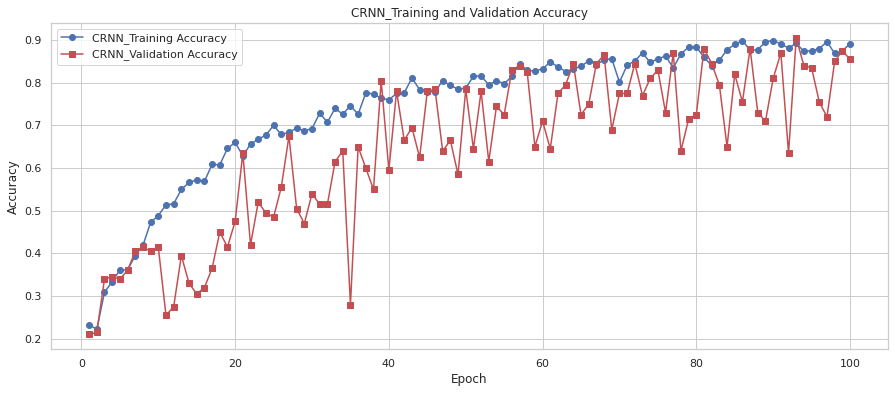

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='CRNN_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='CRNN_Validation Accuracy')
plt.title('CRNN_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [61]:
del scaled_spectrograms1
del scaled_spectrograms1_reshaped

In [62]:
max_length = max(len(audio) for audio, _ in spectrograms_and_labels)
for i, (audio, label) in enumerate(spectrograms_and_labels):
    if len(audio) < max_length:
        spectrograms_and_labels[i] = (np.pad(audio, (0, max_length - len(audio))), label)
    elif len(audio) > max_length:
        spectrograms_and_labels[i] = (audio[:max_length], label)


max_shape = max(S_DB.shape for S_DB, _ in spectrograms_and_labels)
for i, (S_DB, label) in enumerate(spectrograms_and_labels):
    if S_DB.shape != max_shape:
        new_shape = (max_shape[0], max_shape[1])
        spectrograms_and_labels[i] = (np.pad(S_DB, ((0, max_shape[0] - S_DB.shape[0]), (0, max_shape[1] - S_DB.shape[1]))), label)



first_spectrogram_shape = spectrograms_and_labels[0][0].shape


for spectrogram, label in spectrograms_and_labels:
    if spectrogram.shape != first_spectrogram_shape:
        print("Spectrogram shapes are not consistent!")
        break
else:
    print("All spectrograms have consistent shapes:", first_spectrogram_shape)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))


scaled_spectrograms = []

for spectrogram, label in spectrograms_and_labels:
    
    scaled_spectrogram = scaler.fit_transform(spectrogram)
    
    
    
    scaled_spectrograms.append((scaled_spectrogram, label))


All spectrograms have consistent shapes: (20, 270)


In [63]:


X = np.array([item[0] for item in scaled_spectrograms])  # 转换为np.ndarray
y = np.array([item[1] for item in scaled_spectrograms])  # 转换为np.ndarray

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [64]:


l2_reg = 0.001

model = Sequential([
    LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()

history_complex_l2 = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

LSTM_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", LSTM_training_time_minutes)

LSTM_test_loss, LSTM_test_accuracy = model.evaluate(test_dataset)
print("Test accuracy:", LSTM_test_accuracy)


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 16)         │        18,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,253 (98.64 KB)

 Trainable params: 25,253 (98.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1883 - loss: 1.7822 - val_accuracy: 0.2950 - val_loss: 1.7424
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2425 - loss: 1.7377 - val_accuracy: 0.2400 - val_loss: 1.7098
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2387 - loss: 1.7161 - val_accuracy: 0.3300 - val_loss: 1.6512
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2779 - loss: 1.6608 - val_accuracy: 0.3400 - val_loss: 1.5921
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3169 - loss: 1.5798 - val_accuracy: 0.3650 - val_loss: 1.5336
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3423 - loss: 1.5476 - val_accuracy: 0.3500 - val_loss: 1.5517
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3205 - loss: 1.5766 - val_accuracy: 0.2950 - val_loss: 1.5673
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3179 - loss: 1.5491 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5019 - loss: 1.2749
Test accuracy: 0.5199999809265137


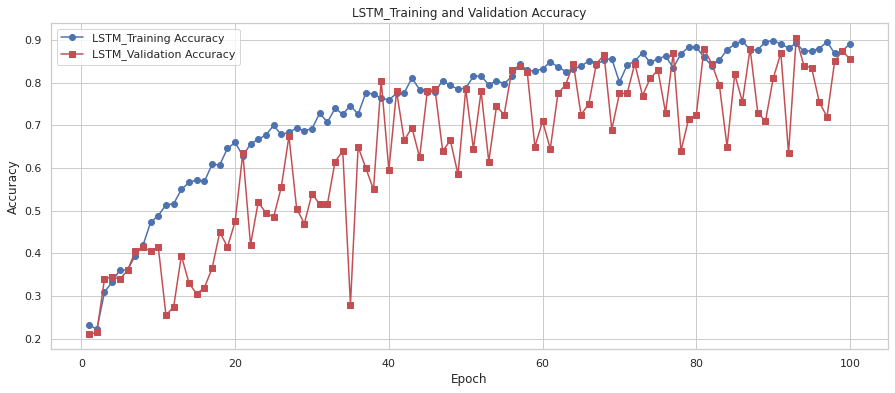

In [65]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='LSTM_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='LSTM_Validation Accuracy')
plt.title('LSTM_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [66]:


l2_reg = 0.001

num_classes = 5

model = Sequential([
    Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(l2_reg))),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()

history_complex_l2 = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

end_time = time.time()

BD_LSTM_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", BD_LSTM_training_time_minutes)

BD_LSTM_test_loss, BD_LSTM_test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {BD_LSTM_test_accuracy:.4f}")


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 20, 32)         │        36,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,501 (212.89 KB)

 Trainable params: 54,501 (212.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.2114 - loss: 1.9568 - val_accuracy: 0.2550 - val_loss: 1.9095
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2166 - loss: 1.9002 - val_accuracy: 0.2450 - val_loss: 1.8519
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1981 - loss: 1.8532 - val_accuracy: 0.2750 - val_loss: 1.8089
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2350 - loss: 1.8263 - val_accuracy: 0.3900 - val_loss: 1.7578
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2880 - loss: 1.7540 - val_accuracy: 0.3850 - val_loss: 1.6684
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3165 - loss: 1.6853 - val_accuracy: 0.4050 - val_loss: 1.5794
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3555 - loss: 1.6721 - val_accuracy: 0.3750 - val_loss: 1.5714
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3107 - loss: 1.6327 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5505 - loss: 1.0922
Test accuracy: 0.5650


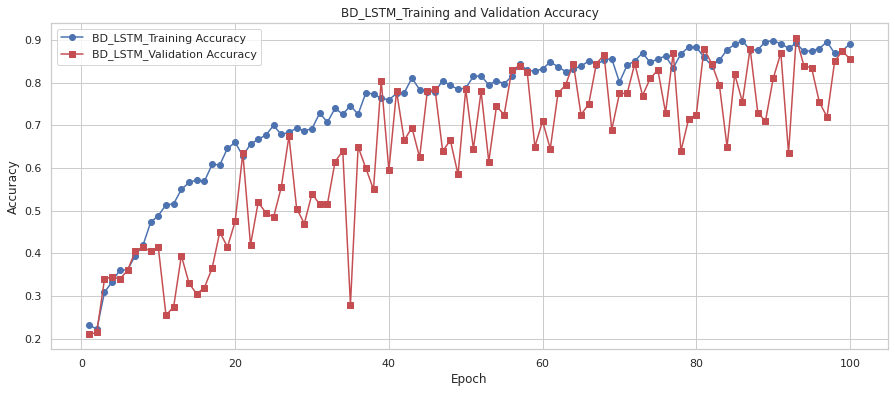

In [67]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='BD_LSTM_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='BD_LSTM_Validation Accuracy')
plt.title('BD_LSTM_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [68]:


l2_reg = 0.001

num_classes = 5

# 定义模型
model = Sequential([
    Bidirectional(GRU(16, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(32, kernel_regularizer=l2(l2_reg))),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

start_time = time.time()

history = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

end_time = time.time()

BD_GRU_training_time_minutes = (end_time - start_time) / 60
print("Training time (minutes):", BD_GRU_training_time_minutes)

BD_GRU_test_loss,BD_GRU_test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {BD_GRU_test_accuracy:.4f}")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 20, 32)         │        27,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        12,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,445 (161.89 KB)

 Trainable params: 41,445 (161.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.2329 - loss: 1.8953 - val_accuracy: 0.2450 - val_loss: 1.8537
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1812 - loss: 1.8656 - val_accuracy: 0.2050 - val_loss: 1.8333
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2241 - loss: 1.8284 - val_accuracy: 0.2050 - val_loss: 1.8035
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2119 - loss: 1.8045 - val_accuracy: 0.3300 - val_loss: 1.7792
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1988 - loss: 1.7787 - val_accuracy: 0.1950 - val_loss: 1.7582
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1918 - loss: 1.7601 - val_accuracy: 0.2900 - val_loss: 1.7368
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2141 - loss: 1.7503 - val_accuracy: 0.1650 - val_loss: 1.7499
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2000 - loss: 1.7482 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5755 - loss: 1.1267
Test accuracy: 0.5750


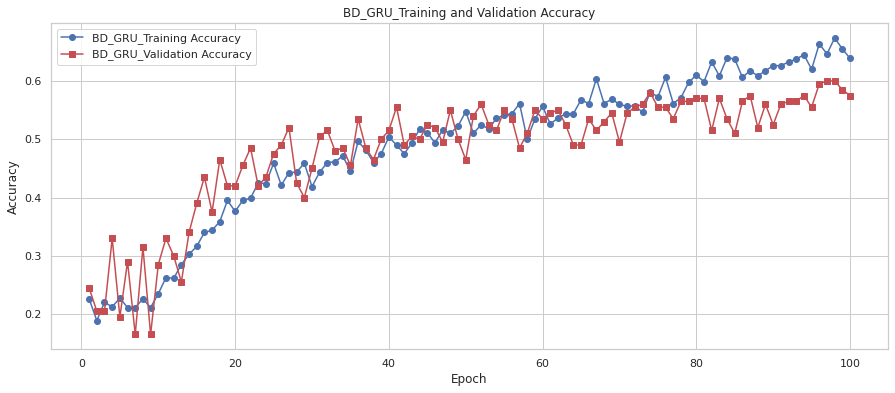

In [69]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting training & validation accuracy
plt.figure(figsize=(15, 6))  

plt.plot(epochs, accuracy, 'bo-', label='BD_GRU_Training Accuracy')
plt.plot(epochs, val_accuracy, 'rs-', label='BD_GRU_Validation Accuracy')
plt.title('BD_GRU_Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


/tmp/ipykernel_3823/3124952762.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  accuracy_bars = sns.barplot(x='Value', y='Model', data=accuracy_data, ax=axes[0], palette='coolwarm')
/tmp/ipykernel_3823/3124952762.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  time_bars = sns.barplot(x='Value', y='Model', data=time_data, ax=axes[1], palette='viridis')


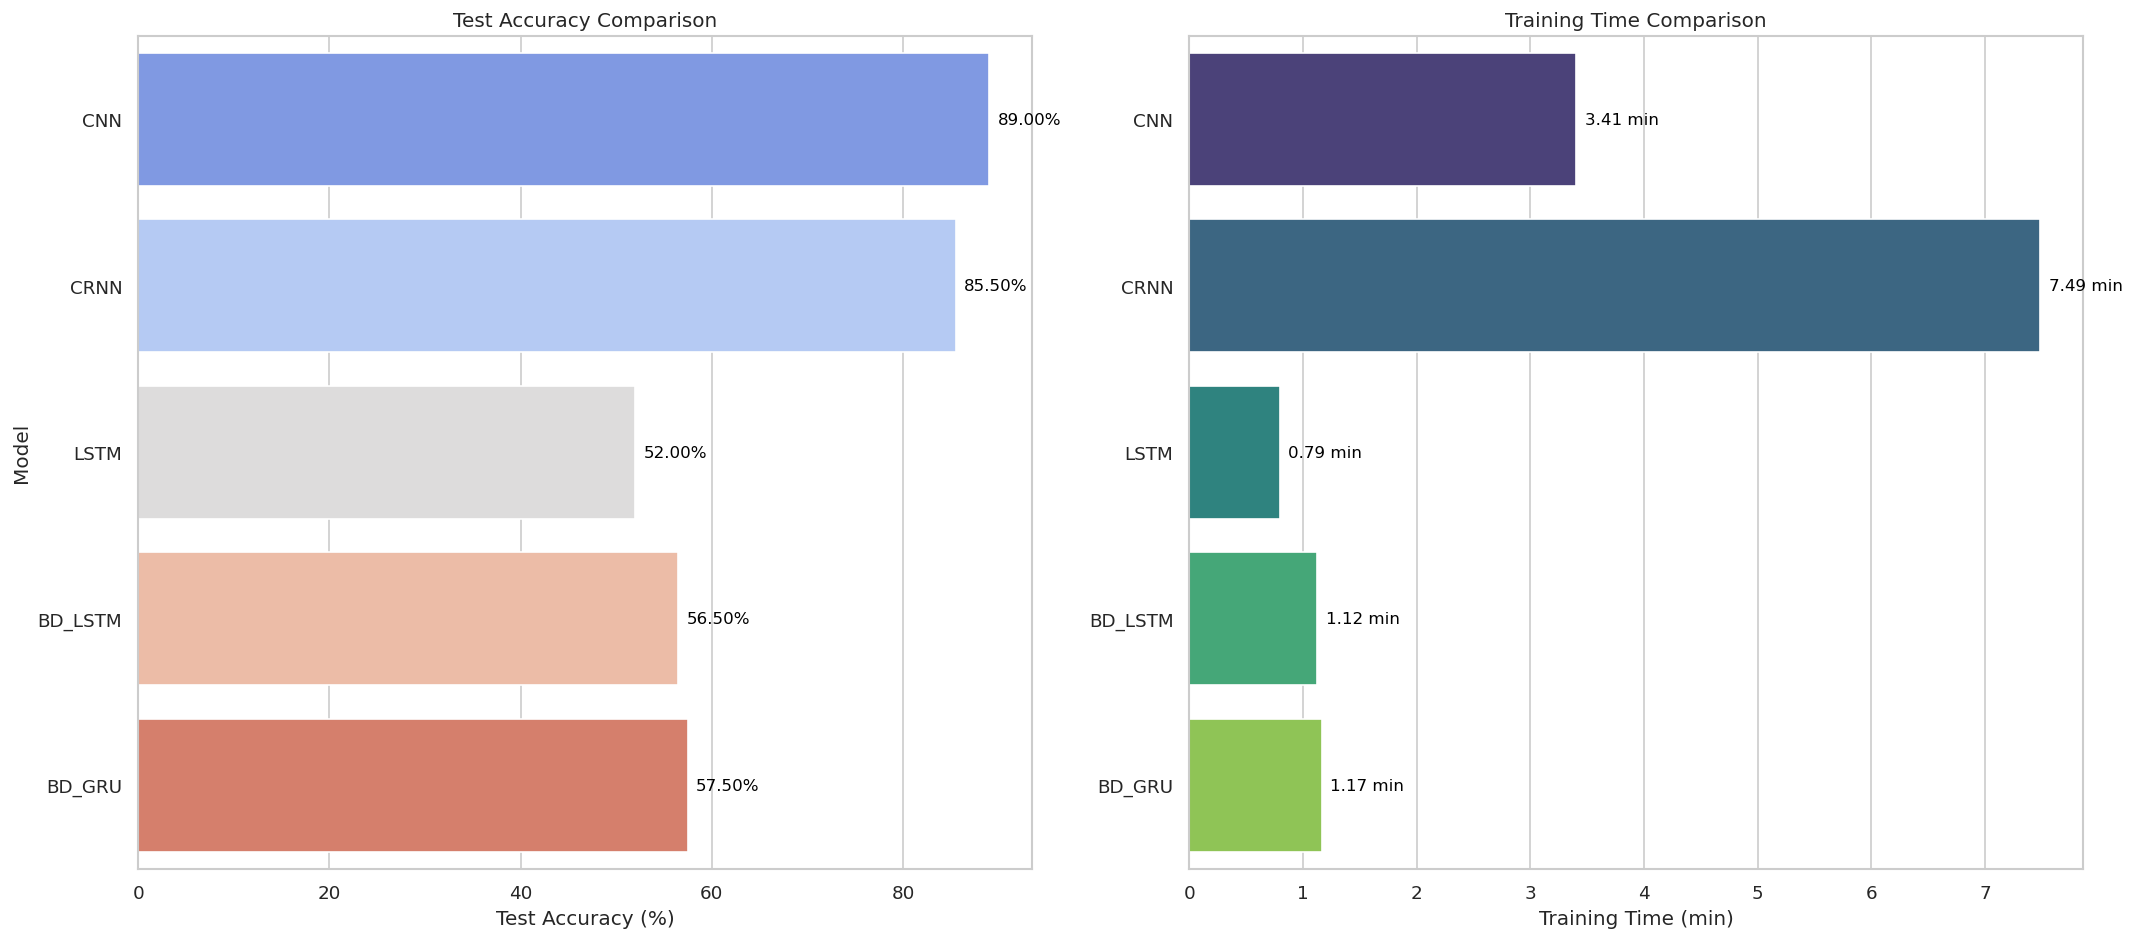

In [71]:
# Model names
models = ['CNN', 'CRNN', 'LSTM', 'BD_LSTM', 'BD_GRU']

# Training time and test accuracy data
training_times = [CNN_training_time_minutes, CRNN_training_time_minutes, LSTM_training_time_minutes, BD_LSTM_training_time_minutes, BD_GRU_training_time_minutes]
test_accuracies = [CNN_test_accuracy, CRNN_test_accuracy, LSTM_test_accuracy, BD_LSTM_test_accuracy, BD_GRU_test_accuracy]

# Prepare data for test accuracy and training time separately
accuracy_data = pd.DataFrame({
    'Model': models,
    'Value': [x * 100 for x in test_accuracies],  # Convert to percentage
    'Type': 'Test Accuracy (%)'
})

time_data = pd.DataFrame({
    'Model': models,
    'Value': training_times,
    'Type': 'Training Time (min)'
})

# Set the plot style
sns.set(style="whitegrid")

# Create subplots for test accuracy and training time comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=120)

# Test accuracy plot with values
accuracy_bars = sns.barplot(x='Value', y='Model', data=accuracy_data, ax=axes[0], palette='coolwarm')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_xlabel('Test Accuracy (%)')
axes[0].set_ylabel('Model')
# Add value labels outside the bars
for p in accuracy_bars.patches:
    axes[0].annotate(f'{p.get_width():.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

# Training time plot with values
time_bars = sns.barplot(x='Value', y='Model', data=time_data, ax=axes[1], palette='viridis')
axes[1].set_title('Training Time Comparison')
axes[1].set_xlabel('Training Time (min)')
axes[1].set_ylabel('')
# Add value labels outside the bars, precise to two decimal places
for p in time_bars.patches:
    axes[1].annotate(f'{p.get_width():.2f} min', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()
